<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 8.2MB 8.7MB/s 


In [ ]:
# импорт библиотек
import numpy as np
from tensorflow.keras.models import Model, load_model
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from gensim.models import word2vec
import os
import pandas as pd
import pymorphy2
import time
import seaborn as sns
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
import tensorflow.keras.backend as K
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова


In [ ]:
directory = '/content/drive/MyDrive/Базы/Договора432.zip (Unzipped Files)/Договора432/' # Путь к папке с договорами
os.listdir(directory)[250:255] # Выведем названия 5-ти договоров

['ДОГОВОР ОБ УЧРЕЖДЕНИИ ОБЩЕСТВА С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ.txt',
 '17.ДОГОВОР НА ПРЕДОСТАВЛЕНИЕ В АРЕНДУ ОБОРУДОВАНИЯ ЛОКАЛЬНОЙ ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ.txt',
 'Коллективный трудовой договор.txt',
 '10 (3).txt',
 '8 (3).txt']

In [ ]:
agreements = []
for filename in os.listdir(directory):
  txt = readText(directory + filename)
  if txt != '':
    agreements.append(readText(directory +  filename))

In [ ]:
n = 4
print(os.listdir(directory)[n])
agreements[n]

Трудовой договор с работником ООО на срок до 2-х месяцев (краткий).txt


'трудовой договор с работником ооо на срок до 2 х месяцев краткий г г в лице действующего на основании именуемый в дальнейшем общество с одной стороны и гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем работник с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 работник принимается на временную работу в общество в качестве 2 <s3> заработная плата работника составляет рублей в месяц </s3> 3 работник <s4> в период работы </s4> в обществе подчиняется непосредственно 4 <s1> работник обязан выполнять следующие должностные обязанности указываются основные характеристики работы и требования к уровню их выполнения вариант выполнять обязанности указанные в должностной инструкции </s1> 5 <s1> работник обязан приступить к работе <s4> с года </s4> </s1> 6 <s4> настоящий трудовой договор заключается на месяца дня/дней не более 2 х месяцев и действует с года до года </s4> 7 <s6> место работы работника </s

In [ ]:
words = []
curTime = time.time()
for i in range(len(agreements)):
  words.append(text2Words(agreements[i]))
print('Затраченное время: ', round(time.time() - curTime, 2), 'c.')

Затраченное время:  140.58 c.


In [ ]:
wordsToTest = words[-10:]
words = words[:-10]

In [ ]:
print('Пример исходного текста:')
print(agreements[4][:62], '\n')
print('Тот же текст, представленный в виде списка из слов в начальной форме:')
print(words[4][:10])

Пример исходного текста:
трудовой договор с работником ооо на срок до 2 х месяцев кратк 

Тот же текст, представленный в виде списка из слов в начальной форме:
['трудовой', 'договор', 'с', 'работник', 'ооо', 'на', 'срок', 'до', '2', 'х']


In [ ]:
tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words)
clean_voc = {}

for item in tokenizer.word_index.items():
  clean_voc[item[0]] = item[1]
  

In [ ]:
print('Словарь всех слов по частоте:') 
print(clean_voc, '\n')
print('Длинна словаря:', len(clean_voc))

tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь всех слов по частоте:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'он': 17, 'за': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, '•': 24, 'работа': 25, 'право': 26, 'срок': 27, '<s4>': 28, '</s4>': 29, 'от': 30, 'они': 31, 'при': 32, '6': 33, 'имущество': 34, 'другой': 35, 'лицо': 36, 'быть': 37, 'день': 38, 'действовать': 39, 'арендатор': 40, 'для': 41, 'условие': 42, '7': 43, 'к': 44, 'если': 45, 'п': 46, 'дальнейший': 47, 'работник': 48, 'а': 49, 'обязательство': 50, 'который': 51, 'страховой': 52, 'законодательство': 53, 'порядок': 54, 'сумма': 55, 'размер': 56, 'действие': 57, 'арендодатель': 58, 'свой': 59, 'соответствие': 60, 'счёт': 61, 'указанный': 62, 'именовать': 63, 'мочь': 64, 'из': 65, 'основание': 66, 'обязанность': 67, 'обязать': 68, 'страховщик': 69, 'исполнение': 70, 'страхователь': 71, 'один': 72, 'иной': 73, 'год': 74, 'тр

In [ ]:
tok_agreem = tokenizer.texts_to_sequences(words)

print('Оригинальный текст:          ', words[4][:20])
print('Последовательность индексов: ', tok_agreem[4][:20])

Оригинальный текст:           ['трудовой', 'договор', 'с', 'работник', 'ооо', 'на', 'срок', 'до', '2', 'х', 'месяц', 'краткий', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать']
Последовательность индексов:  [75, 2, 8, 48, 1820, 10, 27, 76, 4, 662, 146, 2054, 77, 77, 1, 36, 39, 10, 66, 63]


In [ ]:
def get01XSamples(tok_agreem, tags_index):
  tags01 = []
  indexes = []

  for agreement in tok_agreem:
    tag_place = [0,0,0,0,0,0,]
    for ex in agreement:
      if ex in tags_index:
        place = np.argwhere(tags_index == ex)
        if len(place) != 0:
          if place[0][0] < 6:
            tag_place[place[0][0]] = 1
          else:
            tag_place[place[0][0] - 6] = 0
      else:
        tags01.append(tag_place.copy())
        indexes.append(ex)

  return indexes, tags01

def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items()))
  words = [reverse_word_map.get(letter) for letter in x]
  return words

In [ ]:
tags_index = ['<s' + str(i) + '>' for i in range(1, 7)]
closetags = ['</s' + str(i) + '>' for i in range(1, 7)]
tags_index.extend(closetags)

tags_index = np.array([clean_voc[i] for i in tags_index])
print('Индексы тэгов: ', tags_index)

Индексы тэгов:  [ 12 339  22  28 117 280  13 350  23  29 118 271]


In [ ]:
xData, yData = get01XSamples(tok_agreem, tags_index)
decoded_text = reverseIndex(clean_voc, xData)

In [ ]:
print('Длина xData:', len(xData))
print('Длина yData:', len(yData))

print('Посмотрим на исходный набор слов: ', words[0][50:80])
print('Посмотрим на декодированный текст:', decoded_text[50:80])
print('Посмотрим на часть из xData:     ', xData[50:80])
print('Посмотрим на часть из yData:     ', yData[50:80])

Длина xData: 415379
Длина yData: 415379
Посмотрим на исходный набор слов:  ['гр', 'назначаться', 'на', 'должность', 'он', 'осуществлять', 'руководство', 'структурный', 'подразделение', 'выполнять', 'работа', 'в', 'состав', 'который', 'входить', 'руководитель', 'подчиняться', 'непосредственно', 'статья', '2', 'настоящий', 'контракт', 'регулировать', 'трудовой', 'и', 'иной', 'отношение', 'между', 'работодатель', 'и']
Посмотрим на декодированный текст: ['гр', 'назначаться', 'на', 'должность', 'он', 'осуществлять', 'руководство', 'структурный', 'подразделение', 'выполнять', 'работа', 'в', 'состав', 'который', 'входить', 'руководитель', 'подчиняться', 'непосредственно', 'статья', '2', 'настоящий', 'контракт', 'регулировать', 'трудовой', 'и', 'иной', 'отношение', 'между', 'работодатель', 'и']
Посмотрим на часть из xData:      [515, 1550, 10, 485, 17, 211, 871, 1426, 813, 301, 25, 1, 586, 51, 1065, 670, 1427, 710, 430, 4, 9, 183, 1044, 75, 3, 73, 265, 186, 125, 3]
Посмотрим на часть из yData:

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xBatch = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xBatch.append(wordIndexes[index:index+xLen])
    index += step

  return xBatch

In [ ]:
xLen = 256
step = 30
embeddingSize = 300

In [ ]:
xTrain = getSetFromIndexes(decoded_text, xLen, step)
yTrain = getSetFromIndexes(yData, xLen, step)

In [ ]:
print('Длинна xTrain:', len(xTrain))
print('Длинна yTrain:', len(yTrain))
print('Длинна примера из xTrain:',len(xTrain[0]))
print('Длинна примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длинна xTrain: 13778
Длинна yTrain: 13778
Длинна примера из xTrain: 256
Длинна примера из yTrain: 256 

Пример xTrain ['трудовой', 'контракт', 'с', 'генеральный', 'директор', 'товарищество', 'с', 'ограниченный', 'ответственность', 'г', 'г', '1', 'общий', 'положение', '1', '1', 'настоящий', 'контракт', 'заключить', 'между', 'товарищество', 'с', 'ограниченный', 'ответственность', 'именовать', 'в', 'дальнейший', 'товарищество', 'в', 'лицо', 'председатель', 'совет', 'участник', 'товарищество', 'действовать', 'на', 'основание', 'решение', 'общий', 'собрание', 'товарищество', 'протокол', 'от', 'год', 'с', 'один', 'сторона', 'и', 'гражданин', 'российский', 'федерация', 'именовать', 'в', 'дальнейший', 'директор', 'с', 'другой', 'сторона', '1', '2', 'настоящий', 'контракт', 'регулировать', 'трудовой', 'и', 'иной', 'отношение', 'между', 'директор', 'и', 'товарищество', 'определять', 'право', 'обязанность', 'и', 'ответственность', 'директор', 'перед', 'товарищество', 'устанавливать', 'размер', 'о

In [ ]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

# Сегментация текста на базе договоров
 

Попробуем для начала сверточную модель

In [ ]:
# функция создания сверточной сети
def create_Conv1d(xLen, embeddingSize): 
  text_input_layer = Input((xLen,embeddingSize)) 
  text_layer = Conv1D(64, 3, padding='same',activation='relu')(text_input_layer)
  text_layer = Conv1D(64, 3, padding='same',activation='relu')(text_layer)
  text_layer = Conv1D(32, 3, padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(16, 3, padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(yTrainGENSIM.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)
  model.compile(optimizer=Adadelta(0.01),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
  return model

In [ ]:
def getSets(model, senI, tagI):
  xVector = []
  tmp = []
  for text in senI:
    tmp = []
    for word in text:
      tmp.append(model[word])

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)
  

In [ ]:
modelGENSIM = word2vec.Word2Vec(xTrain, size=embeddingSize, window=10,
                                min_count=1, workers=10, iter=10)

In [ ]:
modelGENSIM['соглашение']

In [ ]:
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
print('xTrain:', xTrainGENSIM.shape)
print('yTrain:', yTrainGENSIM.shape)

xTrain: (13778, 256, 300)
yTrain: (13778, 256, 6)


In [ ]:
# np.save('/content/drive/MyDrive/Домашнее задание №27/xTrainGENSIM.npy', xTrainGENSIM) #Сохраняем массивы в память колаба
# np.save('/content/drive/MyDrive/Домашнее задание №27/yTrainGENSIM.npy', yTrainGENSIM) #Сохраняем массивы в память колаба

In [ ]:
xTrainGENSIM = np.load('/content/drive/MyDrive/Домашнее задание №27/xTrainGENSIM.npy') #Загружаем массивы из памяти колаба
yTrainGENSIM = np.load('/content/drive/MyDrive/Домашнее задание №27/yTrainGENSIM.npy') #Загружаем массивы из памяти колаба

In [ ]:
my_model = create_Conv1d(xLen, embeddingSize)
my_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 300)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 64)           57664     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 64)           12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 32)           6176      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 16)           1552      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 256, 6)           

In [ ]:
history = my_model.fit(xTrainGENSIM, yTrainGENSIM, 
                       epochs=40,
                       batch_size=200,
                       validation_split=0.2)

Epoch 1/40
56/56 [==============================] - 4s 68ms/step - loss: 1.2996 - dice_coef: 0.1914 - val_loss: 1.3840 - val_dice_coef: 0.2157
Epoch 2/40
56/56 [==============================] - 3s 59ms/step - loss: 1.2496 - dice_coef: 0.2043 - val_loss: 1.3370 - val_dice_coef: 0.2292
Epoch 3/40
56/56 [==============================] - 3s 59ms/step - loss: 1.2177 - dice_coef: 0.2141 - val_loss: 1.3020 - val_dice_coef: 0.2408
Epoch 4/40
56/56 [==============================] - 3s 58ms/step - loss: 1.1918 - dice_coef: 0.2238 - val_loss: 1.2713 - val_dice_coef: 0.2522
Epoch 5/40
56/56 [==============================] - 3s 59ms/step - loss: 1.1685 - dice_coef: 0.2345 - val_loss: 1.2431 - val_dice_coef: 0.2636
Epoch 6/40
56/56 [==============================] - 3s 60ms/step - loss: 1.1465 - dice_coef: 0.2438 - val_loss: 1.2173 - val_dice_coef: 0.2743
Epoch 7/40
56/56 [==============================] - 3s 58ms/step - loss: 1.1243 - dice_coef: 0.2533 - val_loss: 1.1905 - val_dice_coef: 0.2853

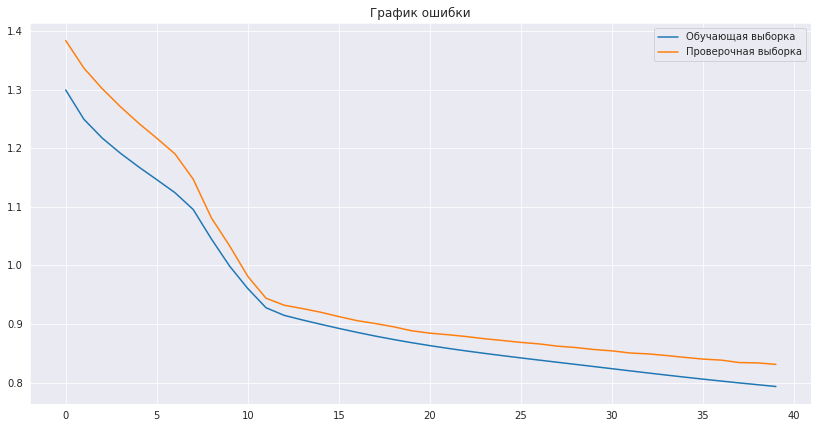

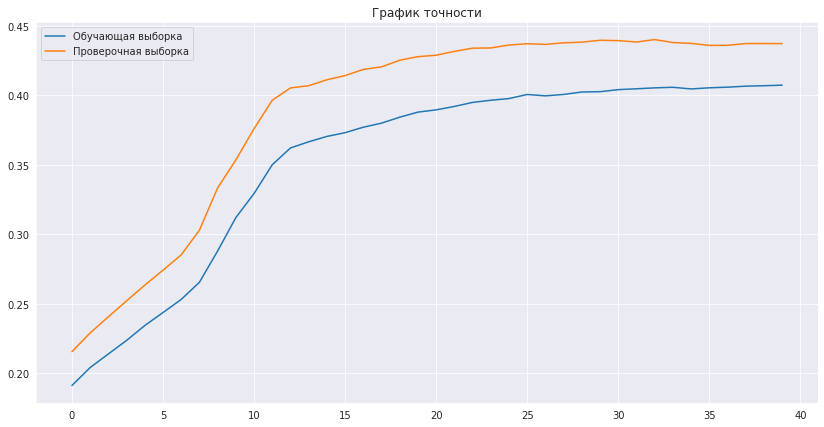

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

По графикам также видно что есть куда расти, попробуем дообучить сеть ещё на нескольких эпохах

In [ ]:
history = my_model.fit(xTrainGENSIM, yTrainGENSIM, 
                       epochs=160,
                       batch_size=200,
                       validation_split=0.2)

Epoch 1/160
56/56 [==============================] - 3s 62ms/step - loss: 0.7903 - dice_coef: 0.4081 - val_loss: 0.8300 - val_dice_coef: 0.4375
Epoch 2/160
56/56 [==============================] - 3s 59ms/step - loss: 0.7875 - dice_coef: 0.4087 - val_loss: 0.8285 - val_dice_coef: 0.4378
Epoch 3/160
56/56 [==============================] - 3s 59ms/step - loss: 0.7848 - dice_coef: 0.4090 - val_loss: 0.8238 - val_dice_coef: 0.4382
Epoch 4/160
56/56 [==============================] - 3s 58ms/step - loss: 0.7821 - dice_coef: 0.4096 - val_loss: 0.8248 - val_dice_coef: 0.4357
Epoch 5/160
56/56 [==============================] - 3s 57ms/step - loss: 0.7795 - dice_coef: 0.4102 - val_loss: 0.8202 - val_dice_coef: 0.4383
Epoch 6/160
56/56 [==============================] - 3s 60ms/step - loss: 0.7770 - dice_coef: 0.4100 - val_loss: 0.8182 - val_dice_coef: 0.4377
Epoch 7/160
56/56 [==============================] - 3s 59ms/step - loss: 0.7745 - dice_coef: 0.4109 - val_loss: 0.8185 - val_dice_coef:

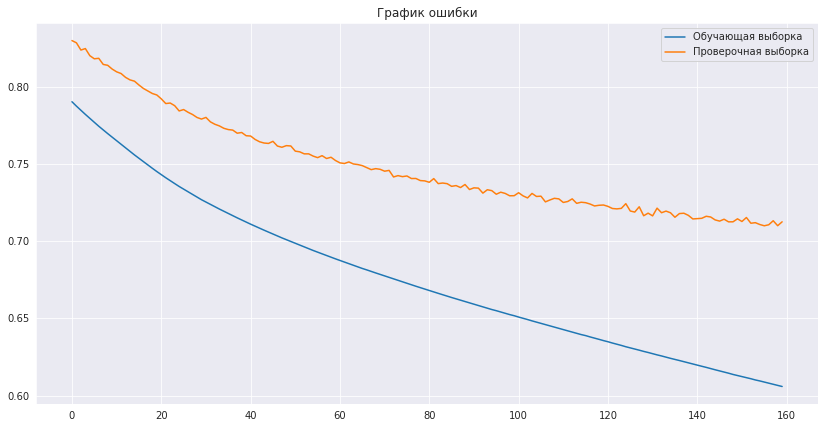

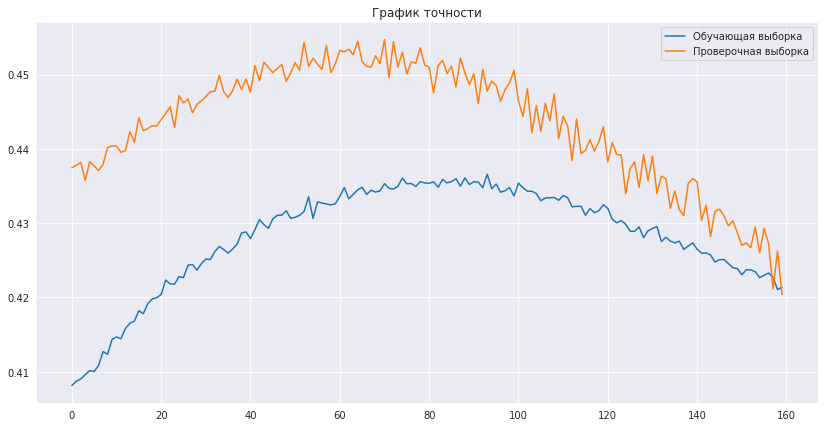

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

по графику обучения видно, что точность после примерно 70ой эпохи начала падать

71 эпоха: loss: 0.6774 - dice_coef: 0.4353 - val_loss: 0.7453 - val_dice_coef: 0.4547

видимо наступило переобучение


также попробуем выжать из этой модели максимум

In [ ]:
# Функция для создания линейной cnonv1d-сети
def lite_Conv1d(xLen, embeddingSize): 
  text_input_layer = Input((xLen,embeddingSize)) 
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_input_layer)
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_layer)
  text_layer = Conv1D(16, 3,padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(yTrainGENSIM.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)
  model.compile(optimizer=Adadelta(0.01),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
  return model

In [ ]:
model_conv1d = lite_Conv1d(xLen, embeddingSize) # Создаем простую сеть

In [ ]:
def save_hist(history, PATH):
  hist_df = pd.DataFrame(history.history) 
  hist_df.to_excel(PATH)

попробуем разные размеры батчей

######################### РАЗМЕР БАТЧА 200 #########################



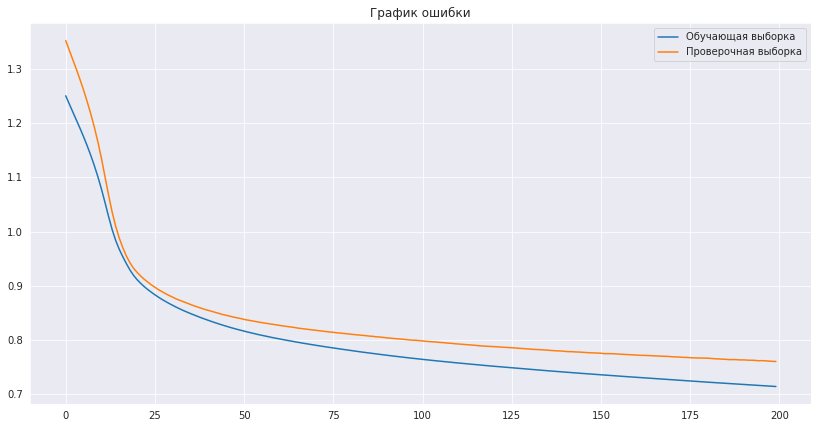

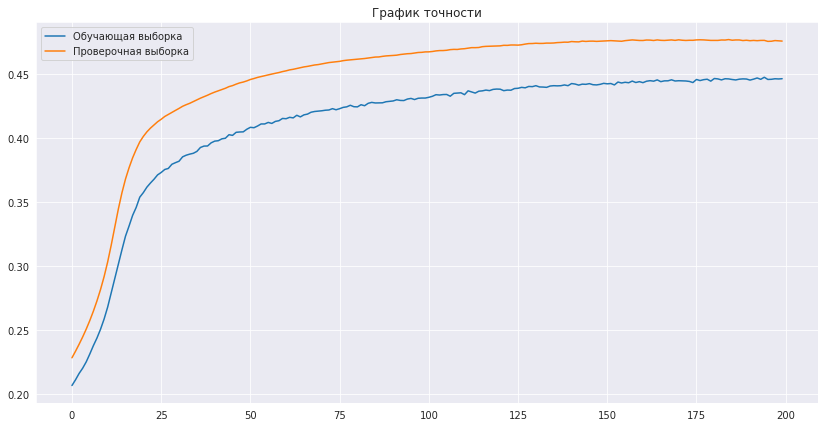


######################### РАЗМЕР БАТЧА 220 #########################



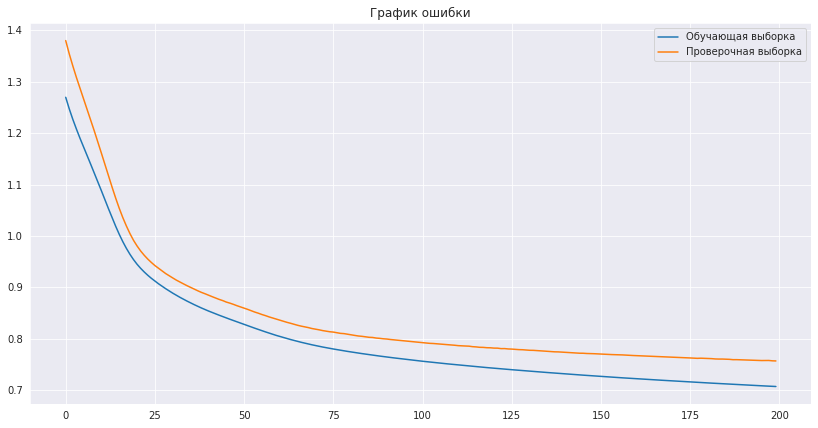

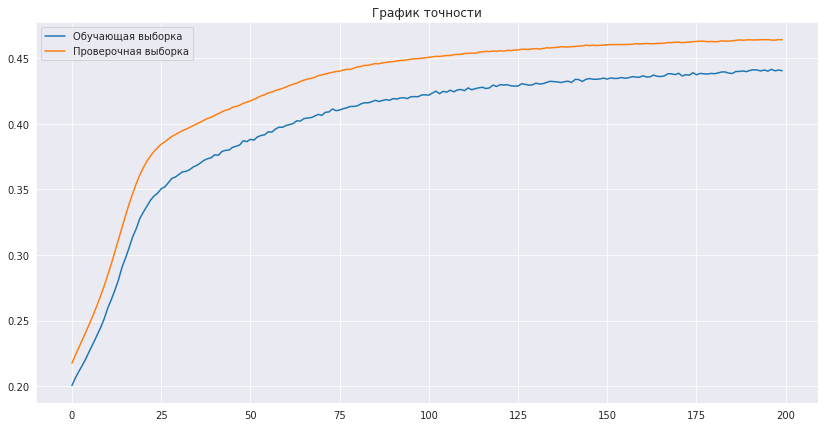


######################### РАЗМЕР БАТЧА 240 #########################



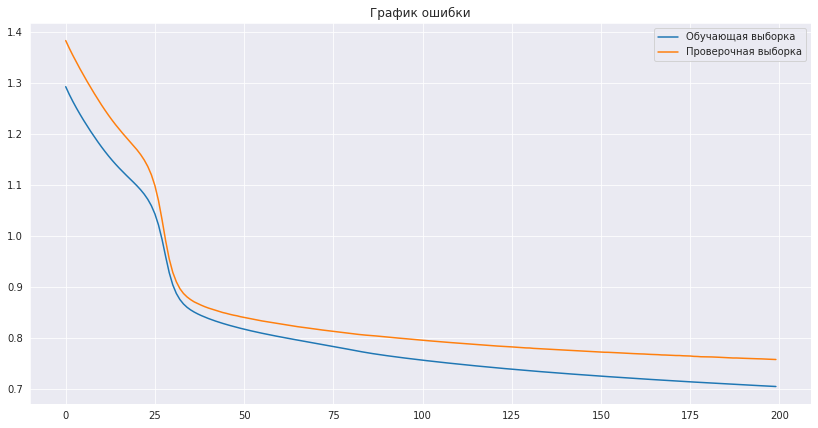

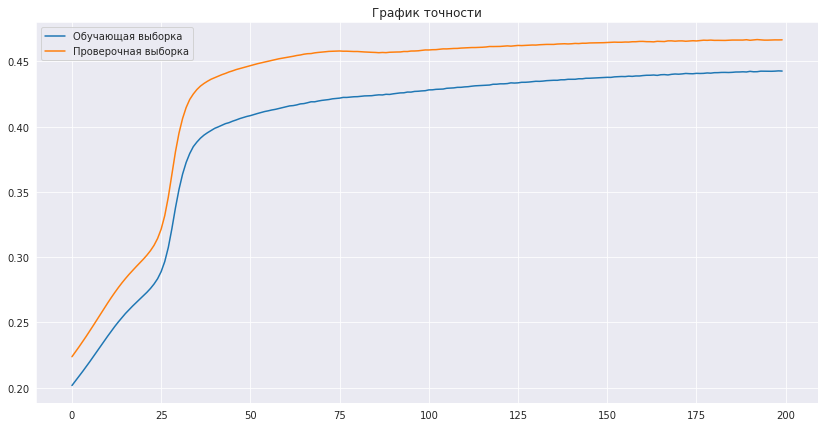


######################### РАЗМЕР БАТЧА 260 #########################



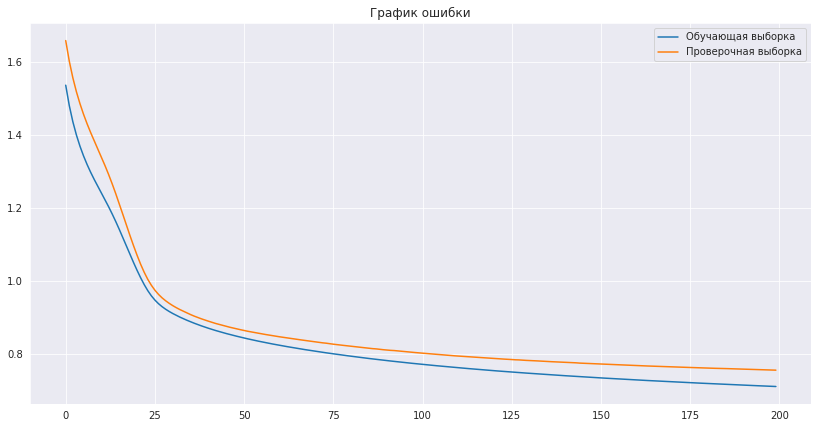

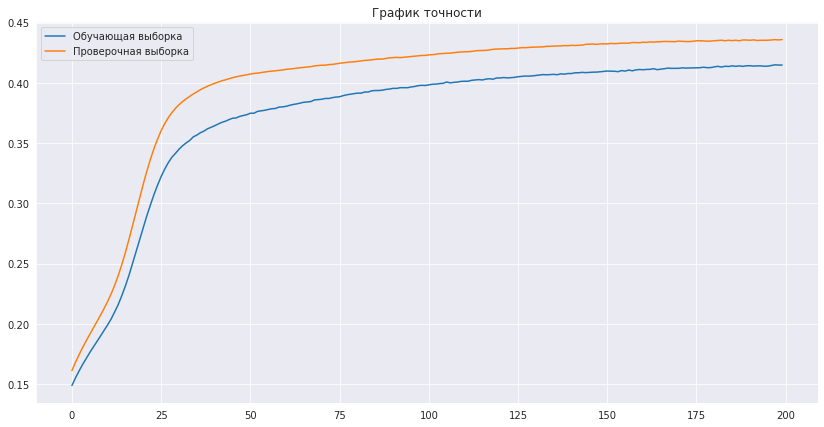


######################### РАЗМЕР БАТЧА 280 #########################



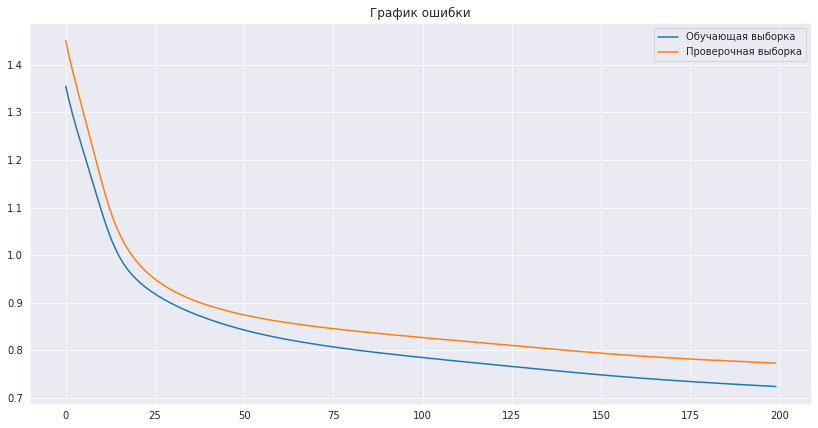

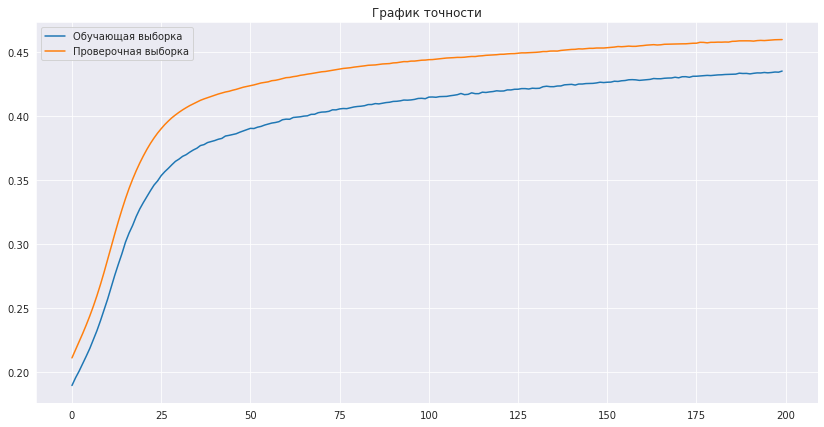


######################### РАЗМЕР БАТЧА 300 #########################



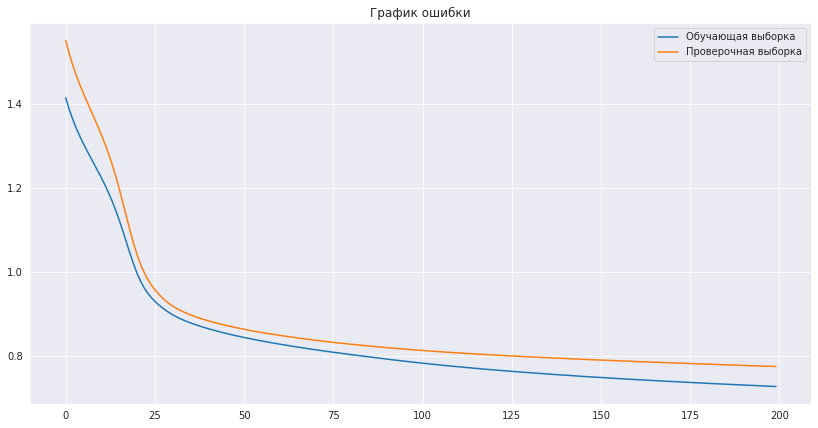

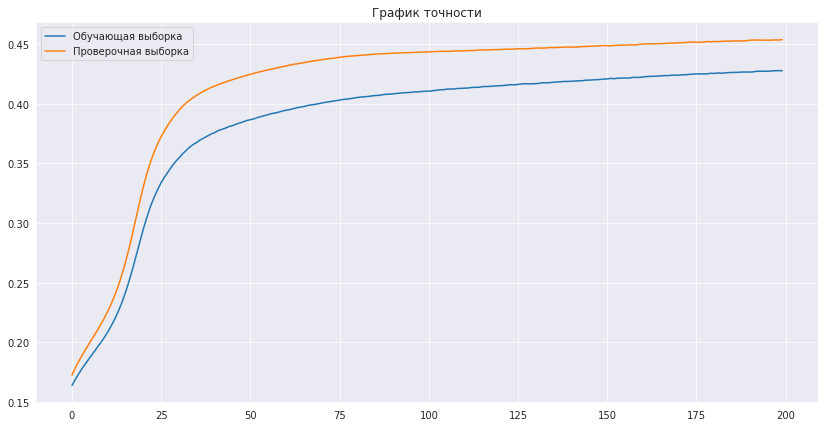


######################### РАЗМЕР БАТЧА 320 #########################



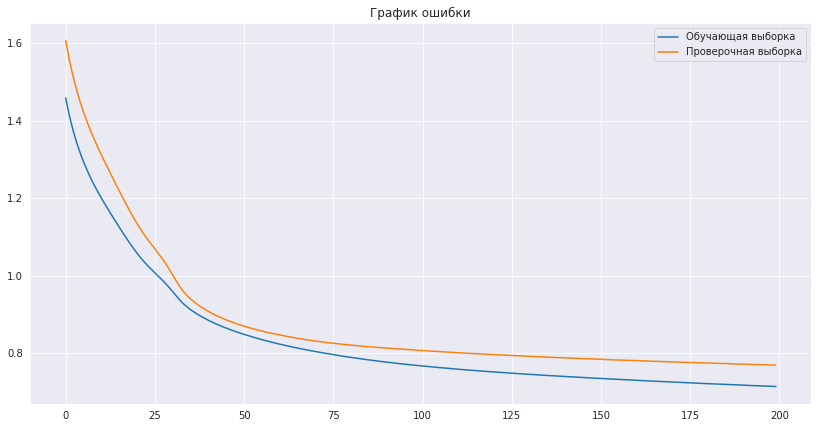

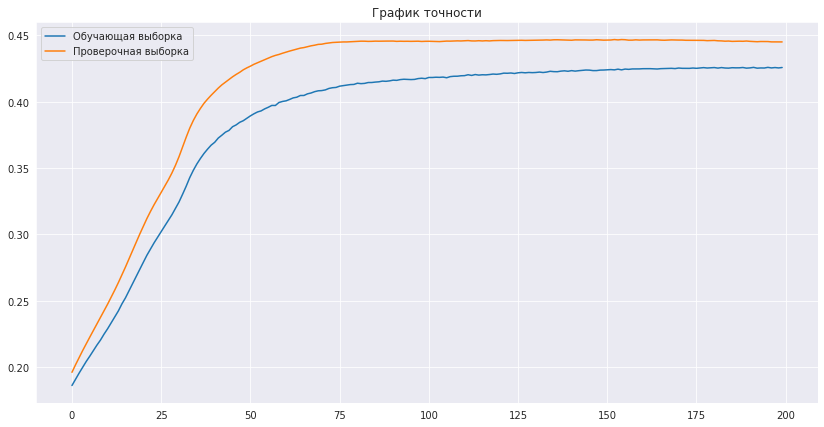


######################### РАЗМЕР БАТЧА 340 #########################



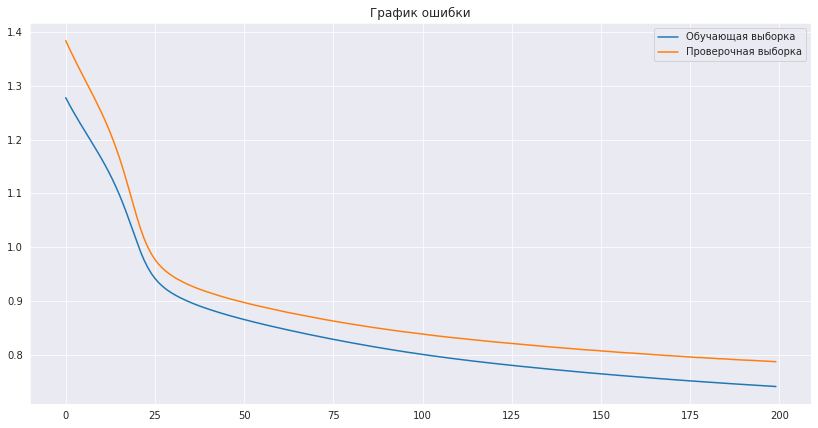

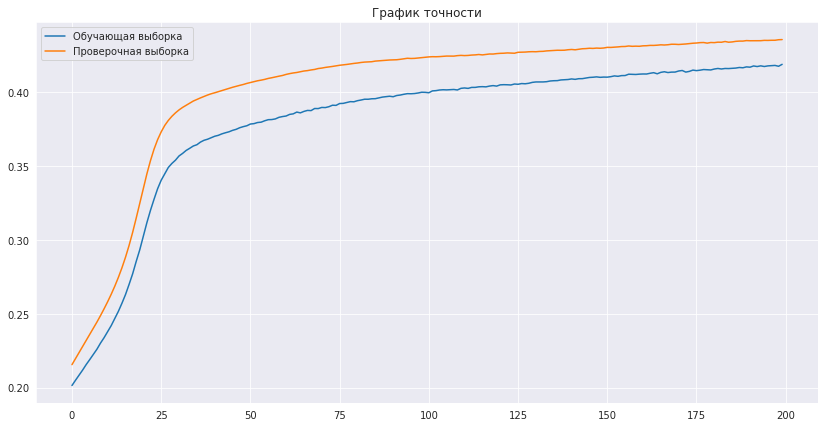


######################### РАЗМЕР БАТЧА 360 #########################



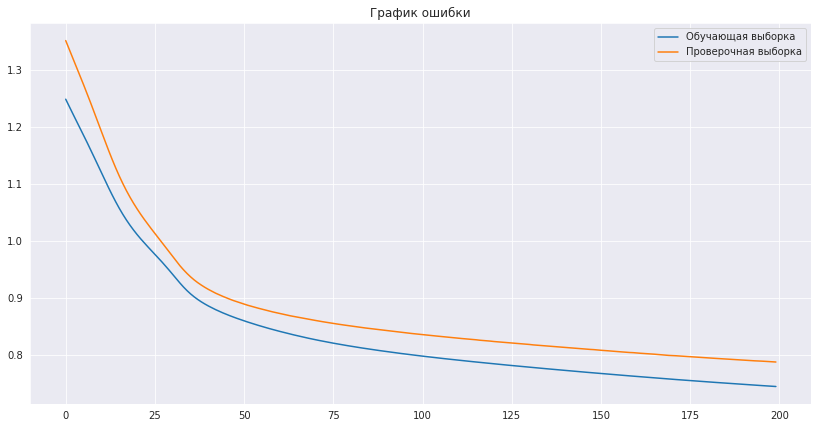

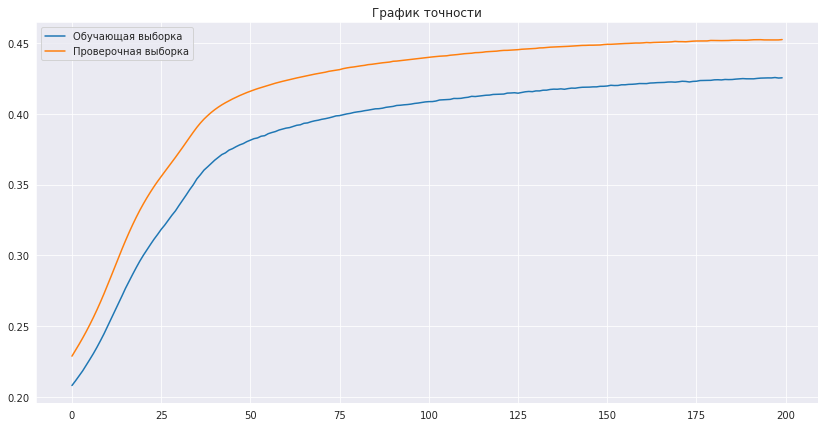


######################### РАЗМЕР БАТЧА 380 #########################



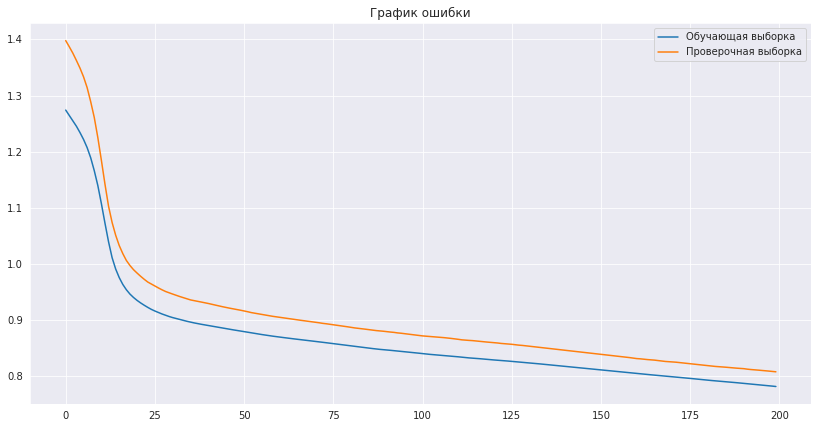

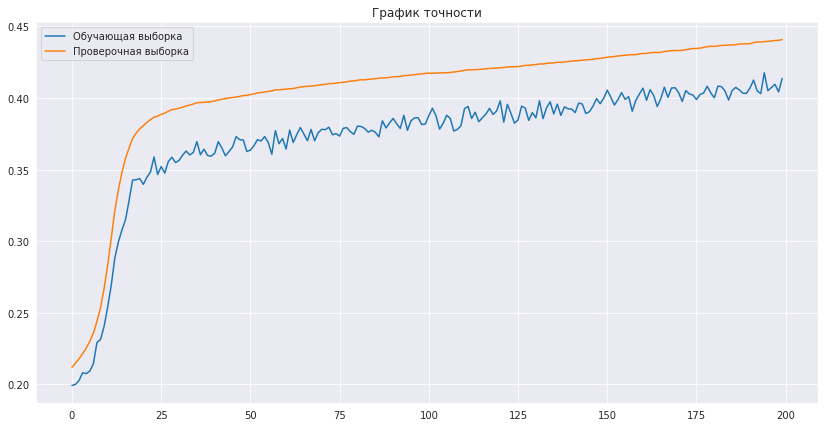


######################### РАЗМЕР БАТЧА 400 #########################



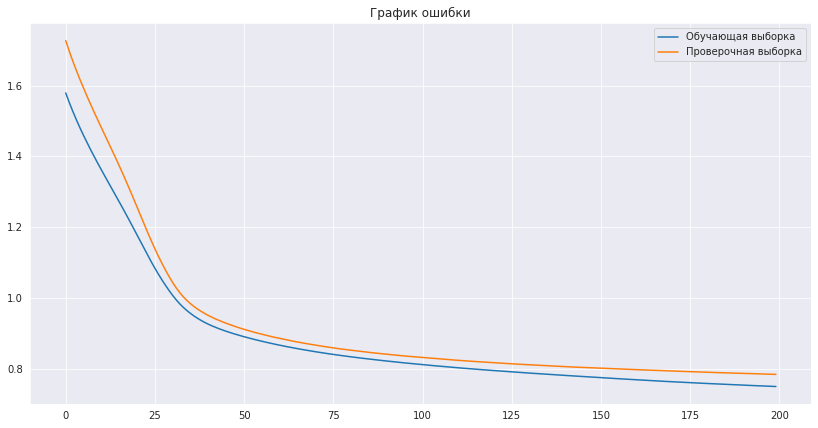

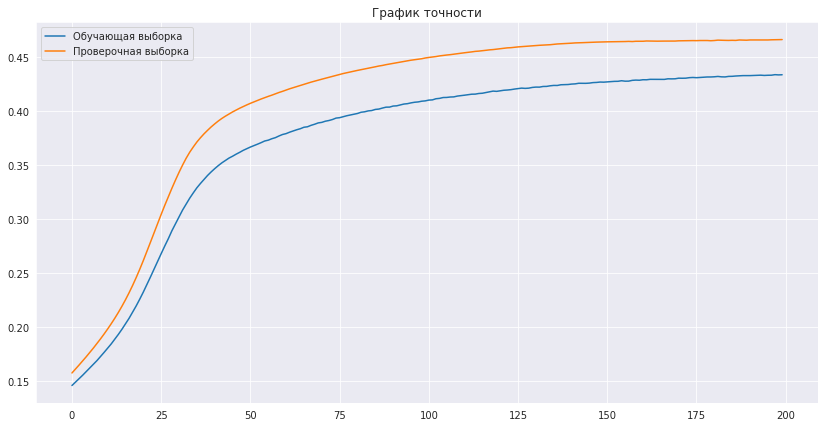


######################### РАЗМЕР БАТЧА 420 #########################



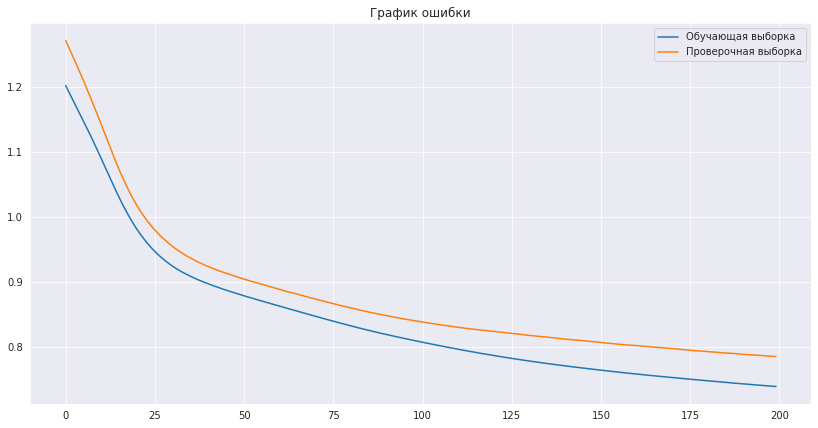

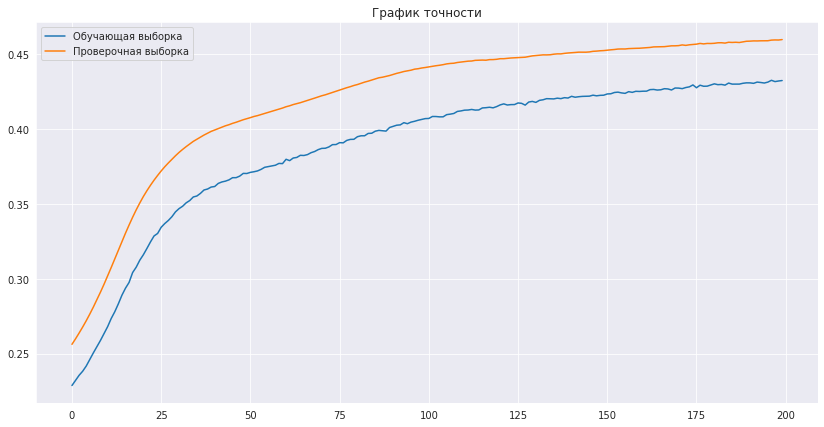


######################### РАЗМЕР БАТЧА 440 #########################



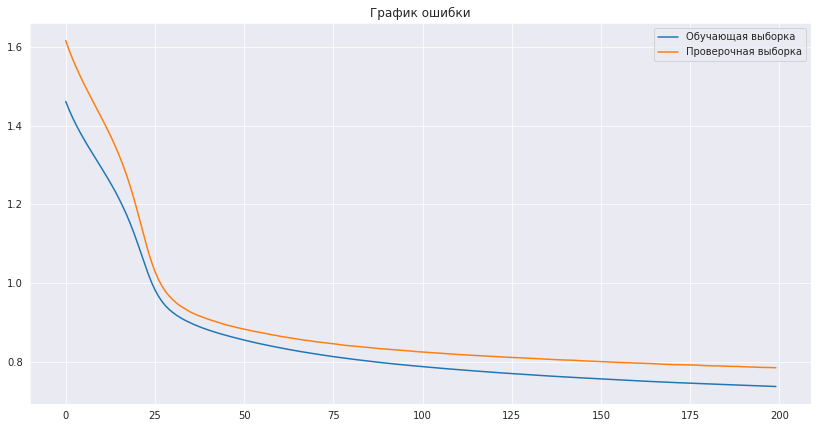

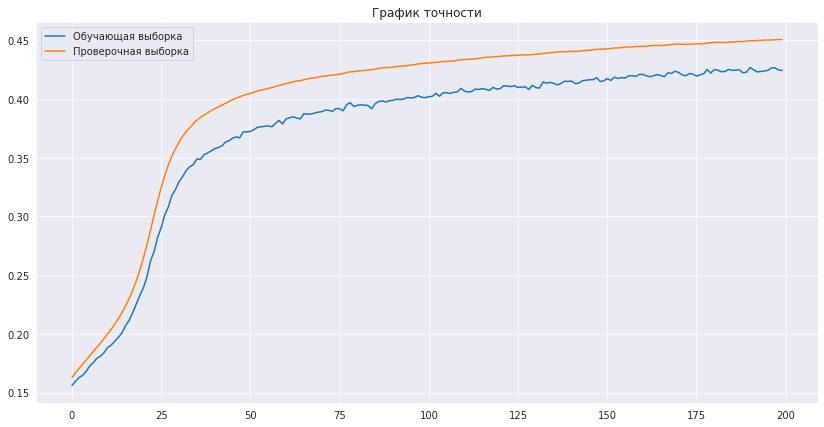


######################### РАЗМЕР БАТЧА 460 #########################



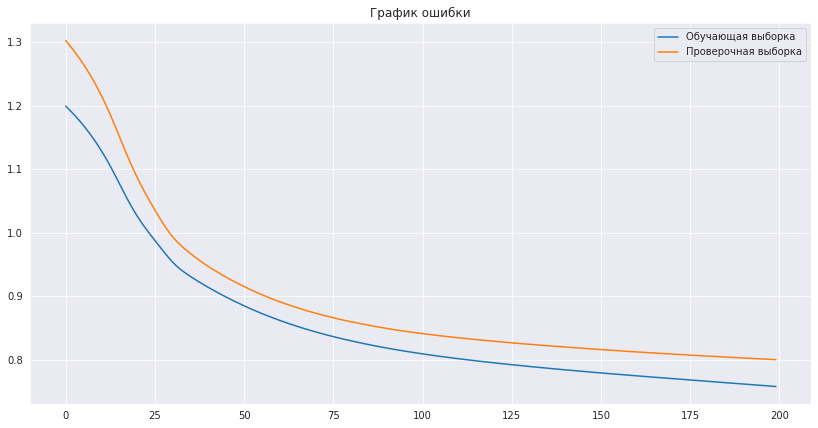

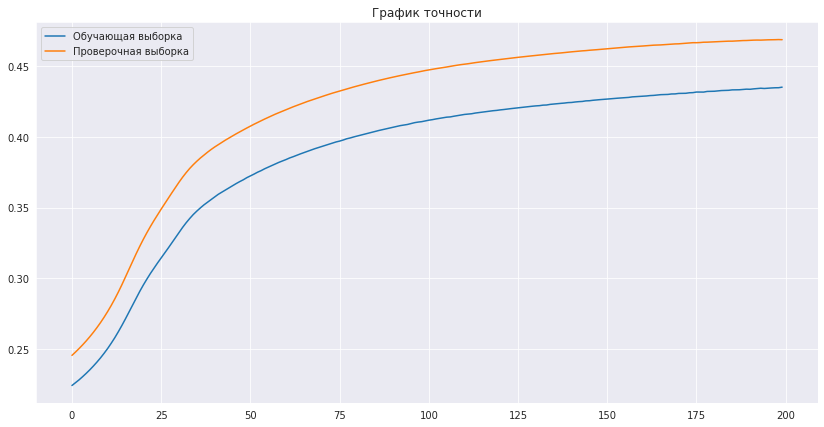


######################### РАЗМЕР БАТЧА 480 #########################



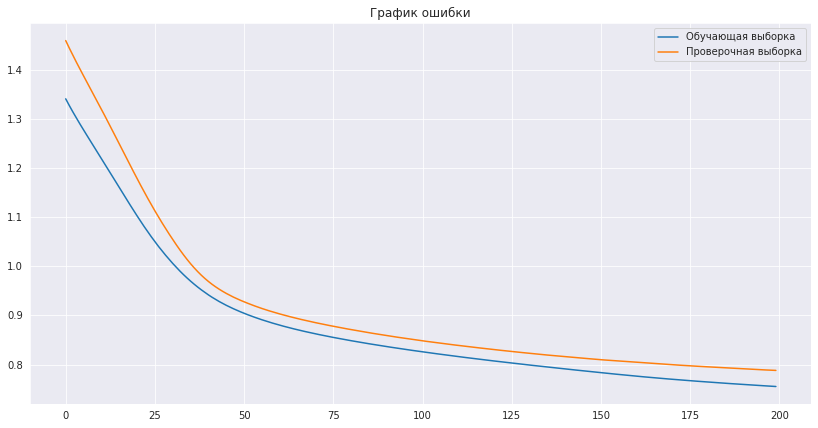

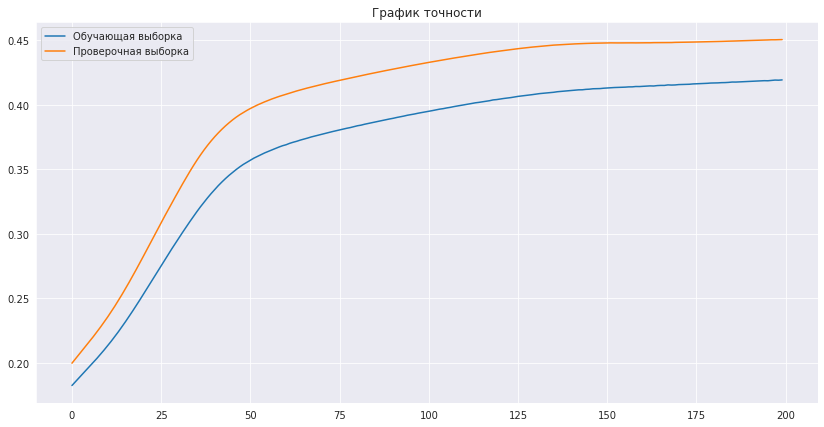


######################### РАЗМЕР БАТЧА 500 #########################



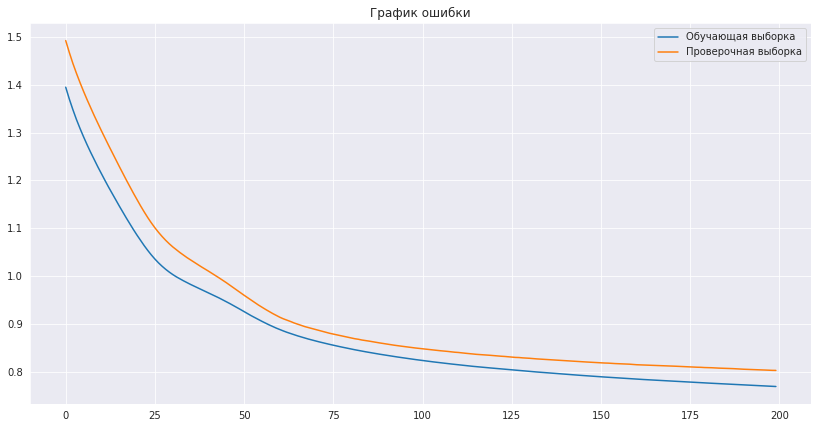

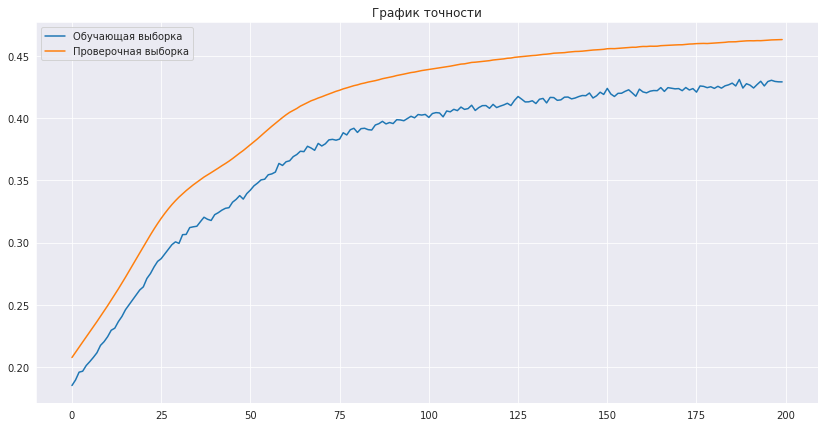

In [ ]:
for batch in range(200, 520, 20):
  model_conv1d = lite_Conv1d(xLen, embeddingSize) 
  history = model_conv1d.fit(xTrainGENSIM, yTrainGENSIM, epochs=200, batch_size=batch, validation_split = 0.2, verbose=0) # Скармливаем модели полученные вектора
  save_hist(history, f'/content/drive/MyDrive/Домашнее задание №27/hist_batch_{batch}.xlsx')
  print(f'######################### РАЗМЕР БАТЧА {batch} #########################')
  print()
  plt.figure(figsize=(14,7))
  plt.plot(history.history['loss'], label='Обучающая выборка')
  plt.plot(history.history['val_loss'], label='Проверочная выборка')
  plt.legend()
  plt.title('График ошибки')
  plt.show()

  plt.figure(figsize=(14,7))
  plt.plot(history.history['dice_coef'], label='Обучающая выборка')
  plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
  plt.legend()
  plt.title('График точности')
  plt.show()
  print()

на 200 эпохе видно, что добавление сверточных слоёв излишне усложнило модель, и на 200 эпохах разница в метриках незаметна, зато виден дальнейший потенциал роста точности, попробуем на лучшей модели увеличить количество эпох до 1000

In [ ]:
all_data = pd.DataFrame()
for batch in range(200, 520, 20):
  df = pd.read_excel(f'/content/drive/MyDrive/Домашнее задание №27/hist_batch_{batch}.xlsx')
  all_data[f'{batch}'] = df['val_dice_coef'] 

In [ ]:
all_data

,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500
0,0.228263,0.217570,0.223749,0.161116,0.210936,0.172591,0.195926,0.215487,0.228950,0.211965,0.157853,0.256151,0.162689,0.245591,0.199613,0.207570
1,0.233398,0.223833,0.227525,0.168006,0.217224,0.178878,0.201598,0.219597,0.233090,0.214828,0.161523,0.259811,0.166747,0.247943,0.203038,0.211748
2,0.238830,0.229851,0.231386,0.174361,0.223507,0.184609,0.207052,0.223662,0.237331,0.217904,0.165241,0.263671,0.170592,0.250427,0.206441,0.215937
3,0.244556,0.235912,0.235339,0.180290,0.229929,0.189914,0.212326,0.227722,0.241729,0.221469,0.169024,0.267681,0.174265,0.253049,0.209850,0.220013
4,0.250724,0.241963,0.239389,0.185894,0.236637,0.194928,0.217454,0.231801,0.246329,0.225356,0.172880,0.271893,0.177875,0.255821,0.213283,0.224089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.475791,0.464279,0.466301,0.435310,0.458900,0.453405,0.445302,0.434987,0.452012,0.439591,0.466089,0.458862,0.450171,0.468442,0.450377,0.462716
196,0.475909,0.463898,0.466403,0.435545,0.459081,0.453410,0.445056,0.435076,0.452050,0.439884,0.466246,0.459282,0.450234,0.468473,0.450491,0.462936
197,0.476424,0.463854,0.466481,0.435797,0.459310,0.453579,0.445061,0.435090,0.452019,0.440216,0.466291,0.459394,0.450424,0.468533,0.450496,0.463028
198,0.476207,0.464235,0.466457,0.435611,0.459383,0.453505,0.445068,0.435448,0.452038,0.440329,0.466419,0.459345,0.450595,0.468619,0.450591,0.463140


из истории обучения видно, что лучший размер батча (320) дал точность 0.435555, также по графику виден потенциал увеличения точности, а значит возьмем этот батч, и запустим с ним обучение на 1000 эпох 

In [ ]:
best_model = lite_Conv1d(xLen, embeddingSize)

In [ ]:
best_history = best_model.fit(xTrainGENSIM, yTrainGENSIM, epochs=1000, batch_size=320, validation_split = 0.2, verbose=1)

save_hist(history, f'/content/drive/MyDrive/Домашнее задание №27/best_hist.xlsx')

plt.figure(figsize=(14,7))
plt.plot(best_history.history['loss'], label='Обучающая выборка')
plt.plot(best_history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(best_history.history['dice_coef'], label='Обучающая выборка')
plt.plot(best_history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()


Epoch 1/1000
35/35 [==============================] - 2s 66ms/step - loss: 0.5996 - dice_coef: 0.3871 - val_loss: 0.7138 - val_dice_coef: 0.3866
Epoch 2/1000
35/35 [==============================] - 2s 63ms/step - loss: 0.5996 - dice_coef: 0.3871 - val_loss: 0.7141 - val_dice_coef: 0.3862
Epoch 3/1000
 4/35 [==>...........................] - ETA: 1s - loss: 0.5886 - dice_coef: 0.3893

KeyboardInterrupt: ignored

Максимальная точность была достигнута на 252 эпохе и составила 0.4613, доучить до 1000 не удалось, произошла неизвестная ошибка, но дальше видна явная тенденция к снижению точности. 

Вывод: Меняя batch_size не удалось добиться высокой точности, необходимо "копать" в сторону улучшения архитектуры или изменению таких гиперпараметров как ОПТИМИЗАТОР или ФУНКЦИЯ ОШИБКИ. Нескольких Conv слоев с ядрами по 16 нейросеть не может "выцепить" более глубокие зависимости даже при большом количестве эпох.   

# Теперь попробуем добиться максимальной точности с использованием сети UNET


In [ ]:
def save_hist(history, PATH):
  hist_df = pd.DataFrame(history.history) 
  hist_df.to_excel(PATH)

In [ ]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
#Функция для создания сети UNET 
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape) 

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling1D()(block_2_out)

    # Block 3
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # x = block_3_out
    x = MaxPooling1D()(block_3_out)

    # Block 4
    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(x, 256, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

попробуем поменять параметры embeddingSize

In [ ]:
xLen = 256
step = 30
embeddingSize = 500

In [ ]:
 # в предыдущем домашнем задании увеличение слоя эмбеддинг дало свои плоды, попробуем этот прием применить и тут 
new_xTrain = getSetFromIndexes(decoded_text, xLen, step)
new_yTrain = getSetFromIndexes(yData, xLen, step)

In [ ]:
new_xTrain = getSetFromIndexes(decoded_text, xLen, step)
new_yTrain = getSetFromIndexes(yData, xLen, step)

In [ ]:
new_modelGENSIM = word2vec.Word2Vec(new_xTrain, size=embeddingSize, window=10,
                                    min_count=1, workers=10, iter=10)

In [ ]:
new_xTrainGENSIM, new_yTrainGENSIM = getSets(new_modelGENSIM, new_xTrain, new_yTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
print('new_xTrain:', new_xTrainGENSIM.shape)
print('new_yTrain:', new_yTrainGENSIM.shape)

new_xTrain: (13838, 256, 500)
new_yTrain: (13838, 256, 6)


In [ ]:
# np.save('/content/drive/MyDrive/Домашнее задание №27/new_xTrainGENSIM.npy', new_xTrainGENSIM) #Сохраняем массивы в память колаба
# np.save('/content/drive/MyDrive/Домашнее задание №27/new_yTrainGENSIM.npy', new_yTrainGENSIM) #Сохраняем массивы в память колаба

In [ ]:
# new_xTrainGENSIM = np.load('/content/drive/MyDrive/Домашнее задание №27/new_xTrainGENSIM.npy', allow_pickle=True) #Загружаем массивы из памяти колаба
# new_yTrainGENSIM = np.load('/content/drive/MyDrive/Домашнее задание №27/new_yTrainGENSIM.npy', allow_pickle=True) #Загружаем массивы из памяти колаба

In [ ]:
my_unet = create_unet(k=1, num_classes=6, input_shape=(xLen, embeddingSize))
my_unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 500)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 64)      96064       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
history = my_unet.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                      batch_size=320, epochs=200, verbose=1, validation_split=0.2) 


Epoch 1/200
35/35 [==============================] - 11s 306ms/step - loss: 0.7021 - dice_coef: 0.4257 - val_loss: 2.0470 - val_dice_coef: 0.3261
Epoch 2/200
35/35 [==============================] - 9s 251ms/step - loss: 0.3686 - dice_coef: 0.5951 - val_loss: 1.0466 - val_dice_coef: 0.4745
Epoch 3/200
35/35 [==============================] - 9s 254ms/step - loss: 0.2805 - dice_coef: 0.6498 - val_loss: 1.3509 - val_dice_coef: 0.4974
Epoch 4/200
35/35 [==============================] - 8s 233ms/step - loss: 0.2415 - dice_coef: 0.6838 - val_loss: 1.0397 - val_dice_coef: 0.5807
Epoch 5/200
35/35 [==============================] - 8s 222ms/step - loss: 0.2129 - dice_coef: 0.7077 - val_loss: 1.1140 - val_dice_coef: 0.5880
Epoch 6/200
35/35 [==============================] - 8s 218ms/step - loss: 0.2040 - dice_coef: 0.7173 - val_loss: 0.9479 - val_dice_coef: 0.5986
Epoch 7/200
35/35 [==============================] - 8s 219ms/step - loss: 0.2115 - dice_coef: 0.7192 - val_loss: 1.1714 - val_di

NameError: ignored

<Figure size 1008x504 with 0 Axes>

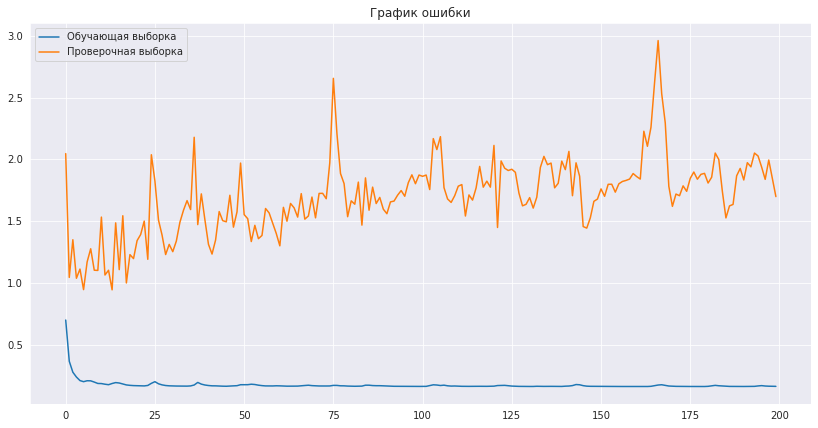

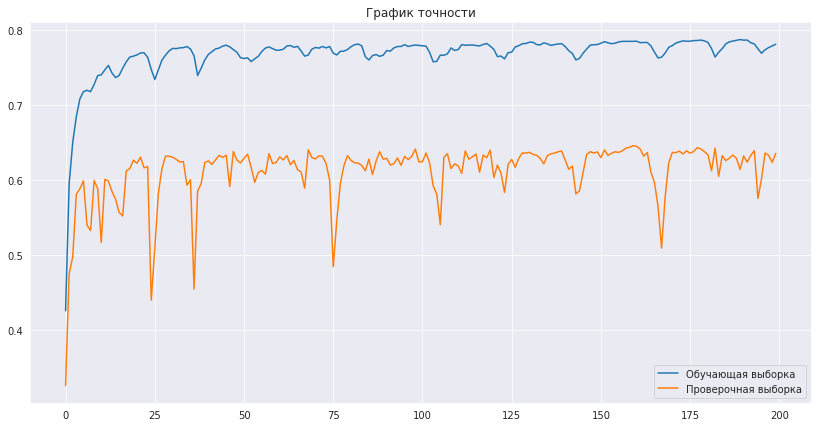

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

судя по графику, можно попробовать уменьшить learning_rate, перекомпилируем нашу модель и запустим ещё на 200 эпох

Epoch 1/200
35/35 [==============================] - 10s 281ms/step - loss: 0.1664 - dice_coef: 0.7810 - val_loss: 1.9165 - val_dice_coef: 0.6337
Epoch 2/200
35/35 [==============================] - 9s 253ms/step - loss: 0.1657 - dice_coef: 0.7833 - val_loss: 1.9344 - val_dice_coef: 0.6400
Epoch 3/200
35/35 [==============================] - 9s 255ms/step - loss: 0.1657 - dice_coef: 0.7840 - val_loss: 1.9050 - val_dice_coef: 0.6356
Epoch 4/200
35/35 [==============================] - 9s 253ms/step - loss: 0.1667 - dice_coef: 0.7829 - val_loss: 2.5032 - val_dice_coef: 0.5820
Epoch 5/200
35/35 [==============================] - 9s 255ms/step - loss: 0.1663 - dice_coef: 0.7825 - val_loss: 2.0263 - val_dice_coef: 0.6391
Epoch 6/200
35/35 [==============================] - 9s 256ms/step - loss: 0.1657 - dice_coef: 0.7823 - val_loss: 2.0486 - val_dice_coef: 0.6345
Epoch 7/200
35/35 [==============================] - 9s 259ms/step - loss: 0.1660 - dice_coef: 0.7826 - val_loss: 2.0303 - val_di

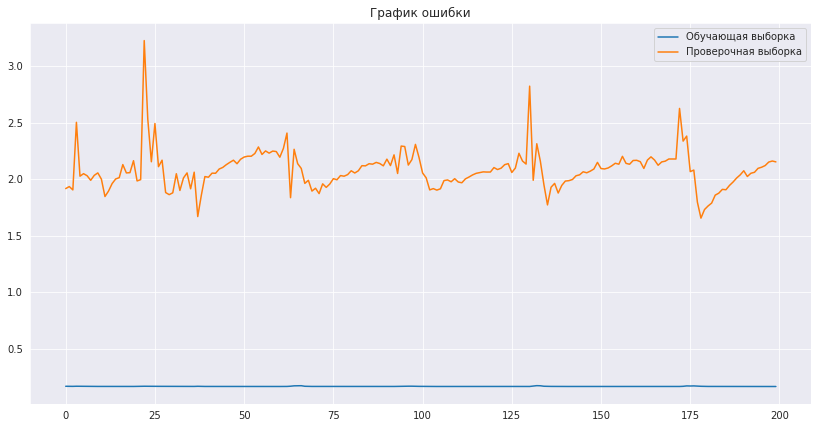

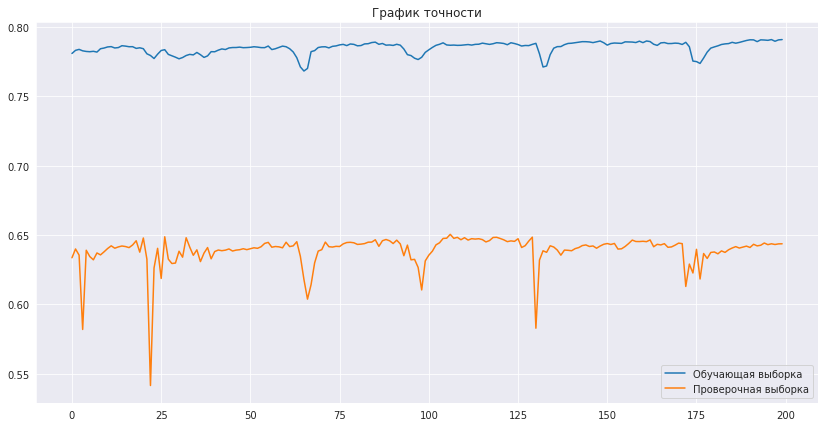

In [ ]:
my_unet.compile(optimizer=Adam(0.0025/2), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
history = my_unet.fit(new_xTrainGENSIM, new_yTrainGENSIM,
            batch_size=320, epochs=200, verbose=1, validation_split=0.2)
 
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

попробуем ещё уменьшить в два раза lerning_rate, в надежде, что пропадет "пила"

Epoch 1/200
35/35 [==============================] - 10s 285ms/step - loss: 0.1648 - dice_coef: 0.7898 - val_loss: 2.3063 - val_dice_coef: 0.6447
Epoch 2/200
35/35 [==============================] - 9s 261ms/step - loss: 0.1644 - dice_coef: 0.7882 - val_loss: 2.3749 - val_dice_coef: 0.6417
Epoch 3/200
35/35 [==============================] - 9s 254ms/step - loss: 0.1644 - dice_coef: 0.7882 - val_loss: 2.2603 - val_dice_coef: 0.6436
Epoch 4/200
35/35 [==============================] - 9s 256ms/step - loss: 0.1644 - dice_coef: 0.7887 - val_loss: 2.2140 - val_dice_coef: 0.6431
Epoch 5/200
35/35 [==============================] - 9s 253ms/step - loss: 0.1644 - dice_coef: 0.7899 - val_loss: 2.2108 - val_dice_coef: 0.6427
Epoch 6/200
35/35 [==============================] - 9s 259ms/step - loss: 0.1644 - dice_coef: 0.7897 - val_loss: 2.1856 - val_dice_coef: 0.6425
Epoch 7/200
35/35 [==============================] - 9s 256ms/step - loss: 0.1644 - dice_coef: 0.7895 - val_loss: 2.2057 - val_di

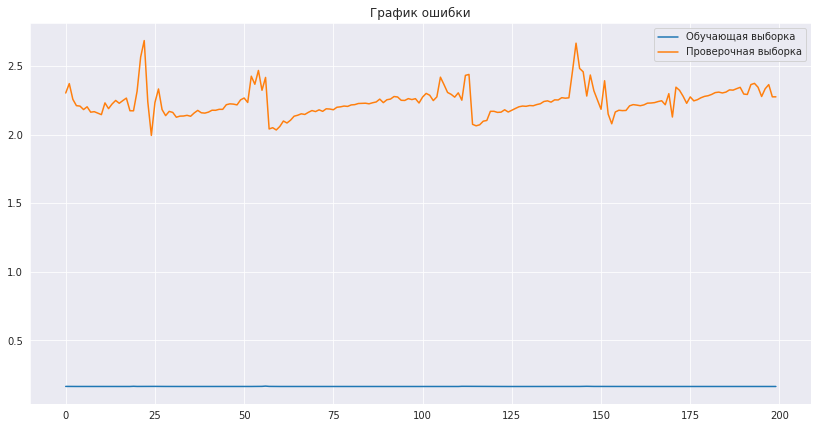

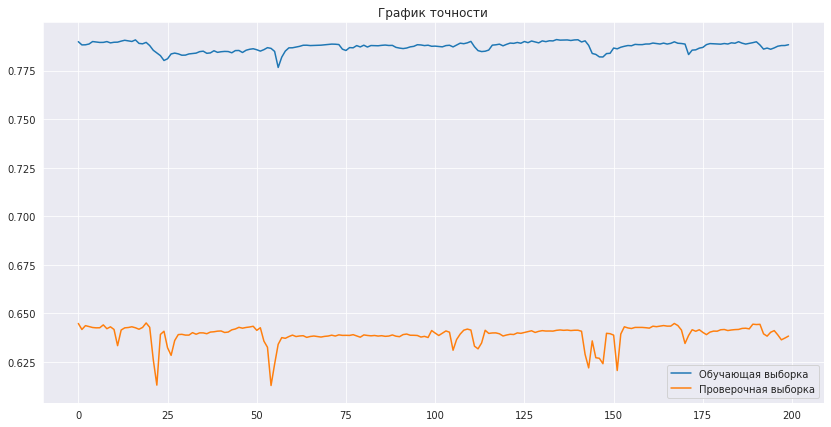

In [ ]:
my_unet.compile(optimizer=Adam(0.0025/4), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
history = my_unet.fit(new_xTrainGENSIM, new_yTrainGENSIM,
            batch_size=320, epochs=200, verbose=1, validation_split=0.2)
 
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

Попробуем поменять сам оптимизатор

Epoch 1/200
35/35 [==============================] - 10s 285ms/step - loss: 0.1643 - dice_coef: 0.7882 - val_loss: 2.3076 - val_dice_coef: 0.6401
Epoch 2/200
35/35 [==============================] - 9s 255ms/step - loss: 0.1643 - dice_coef: 0.7883 - val_loss: 2.3096 - val_dice_coef: 0.6402
Epoch 3/200
35/35 [==============================] - 9s 257ms/step - loss: 0.1643 - dice_coef: 0.7886 - val_loss: 2.3106 - val_dice_coef: 0.6402
Epoch 4/200
35/35 [==============================] - 9s 258ms/step - loss: 0.1643 - dice_coef: 0.7881 - val_loss: 2.3109 - val_dice_coef: 0.6403
Epoch 5/200
35/35 [==============================] - 9s 259ms/step - loss: 0.1643 - dice_coef: 0.7883 - val_loss: 2.3113 - val_dice_coef: 0.6403
Epoch 6/200
35/35 [==============================] - 9s 262ms/step - loss: 0.1643 - dice_coef: 0.7882 - val_loss: 2.3116 - val_dice_coef: 0.6403
Epoch 7/200
35/35 [==============================] - 9s 258ms/step - loss: 0.1643 - dice_coef: 0.7886 - val_loss: 2.3125 - val_di

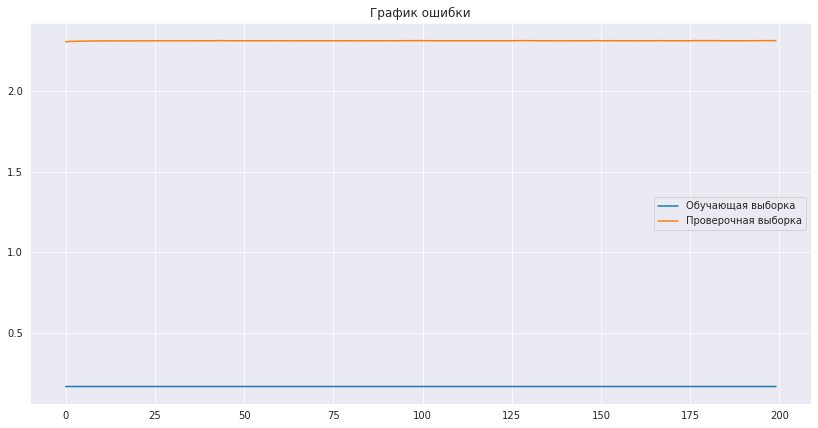

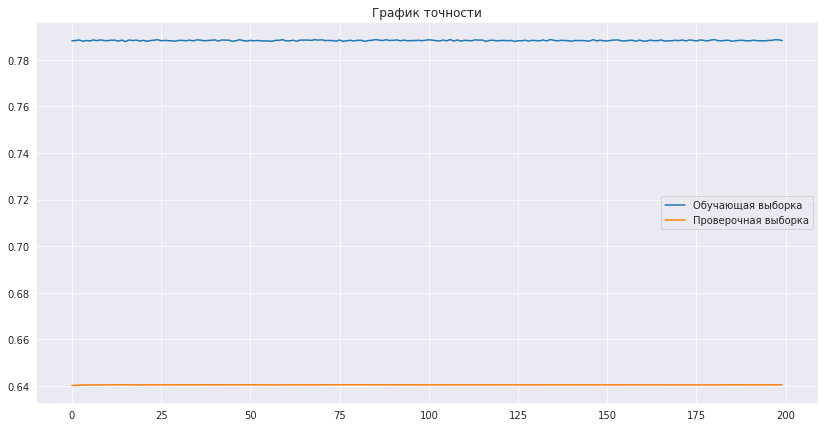

In [ ]:
my_unet.compile(optimizer=Adadelta(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
history = my_unet.fit(new_xTrainGENSIM, new_yTrainGENSIM,
            batch_size=320, epochs=200, verbose=1, validation_split=0.2)
 
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

видно, что точность застопорилась на одном значении, увеличим шаг оптимизатора

Epoch 1/200
35/35 [==============================] - 10s 285ms/step - loss: 0.1643 - dice_coef: 0.7886 - val_loss: 2.3147 - val_dice_coef: 0.6404
Epoch 2/200
35/35 [==============================] - 9s 258ms/step - loss: 0.1643 - dice_coef: 0.7885 - val_loss: 2.3149 - val_dice_coef: 0.6404
Epoch 3/200
35/35 [==============================] - 9s 256ms/step - loss: 0.1643 - dice_coef: 0.7884 - val_loss: 2.3148 - val_dice_coef: 0.6404
Epoch 4/200
35/35 [==============================] - 9s 256ms/step - loss: 0.1643 - dice_coef: 0.7884 - val_loss: 2.3146 - val_dice_coef: 0.6404
Epoch 5/200
35/35 [==============================] - 9s 249ms/step - loss: 0.1643 - dice_coef: 0.7887 - val_loss: 2.3142 - val_dice_coef: 0.6404
Epoch 6/200
35/35 [==============================] - 8s 223ms/step - loss: 0.1643 - dice_coef: 0.7885 - val_loss: 2.3145 - val_dice_coef: 0.6404
Epoch 7/200
35/35 [==============================] - 8s 230ms/step - loss: 0.1643 - dice_coef: 0.7879 - val_loss: 2.3141 - val_di

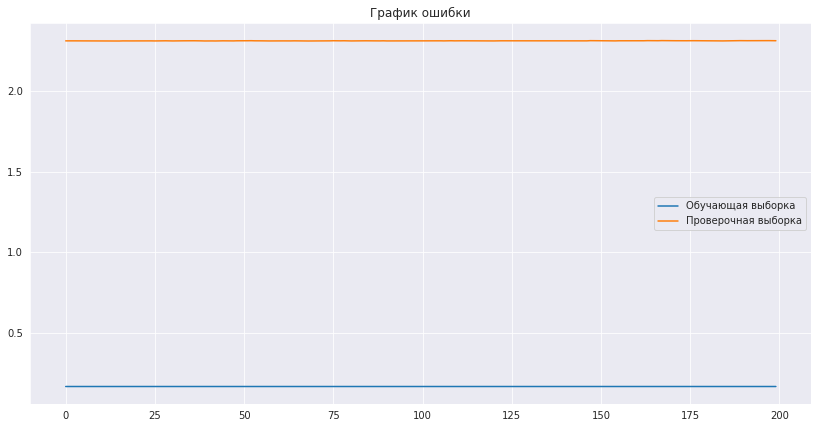

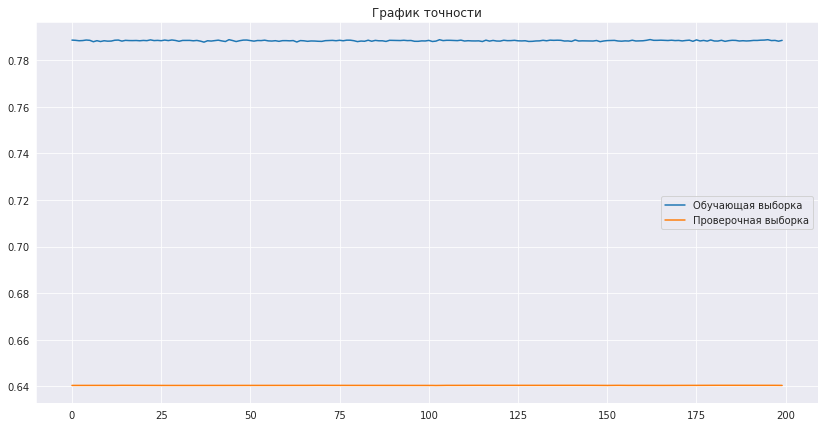

In [ ]:
my_unet.compile(optimizer=Adadelta(0.005), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
history = my_unet.fit(new_xTrainGENSIM, new_yTrainGENSIM,
            batch_size=320, epochs=200, verbose=1, validation_split=0.2)
 
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

Обучение сетей с разным множителем k.

Epoch 1/200
35/35 [==============================] - 17s 498ms/step - loss: 0.6092 - dice_coef: 0.4805 - val_loss: 11.6043 - val_dice_coef: 0.0719
Epoch 2/200
35/35 [==============================] - 15s 431ms/step - loss: 0.3199 - dice_coef: 0.6192 - val_loss: 8.9813 - val_dice_coef: 0.0808
Epoch 3/200
35/35 [==============================] - 15s 434ms/step - loss: 0.2417 - dice_coef: 0.6779 - val_loss: 1.0782 - val_dice_coef: 0.4778
Epoch 4/200
35/35 [==============================] - 15s 434ms/step - loss: 0.2132 - dice_coef: 0.7058 - val_loss: 1.2426 - val_dice_coef: 0.5301
Epoch 5/200
35/35 [==============================] - 15s 434ms/step - loss: 0.1956 - dice_coef: 0.7252 - val_loss: 1.2000 - val_dice_coef: 0.5414
Epoch 6/200
35/35 [==============================] - 15s 434ms/step - loss: 0.1949 - dice_coef: 0.7286 - val_loss: 1.2921 - val_dice_coef: 0.5600
Epoch 7/200
35/35 [==============================] - 15s 431ms/step - loss: 0.1965 - dice_coef: 0.7276 - val_loss: 1.1205 -

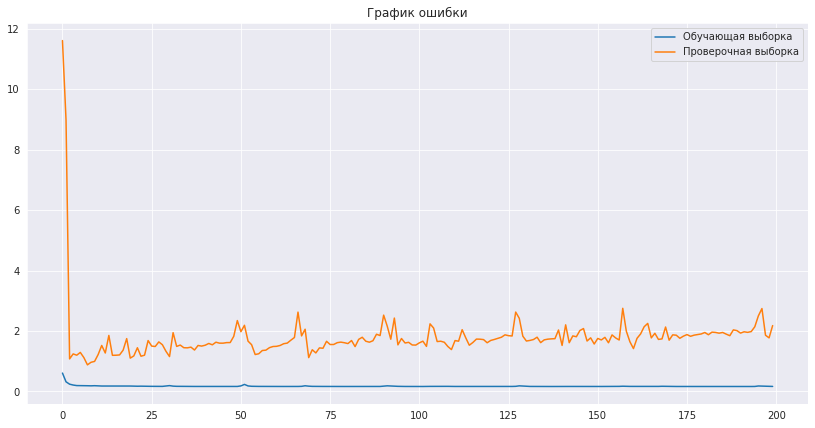

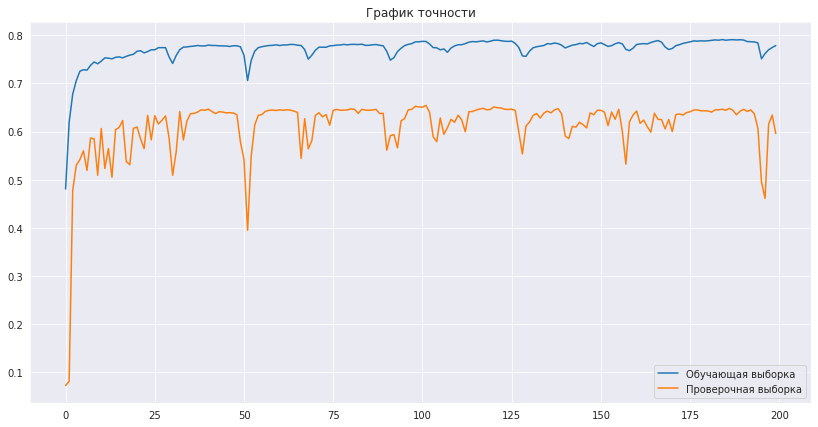

Epoch 1/200
35/35 [==============================] - 26s 738ms/step - loss: 0.6353 - dice_coef: 0.4738 - val_loss: 3.1781 - val_dice_coef: 0.4375
Epoch 2/200
35/35 [==============================] - 23s 671ms/step - loss: 0.3426 - dice_coef: 0.6019 - val_loss: 2.5097 - val_dice_coef: 0.4160
Epoch 3/200
35/35 [==============================] - 23s 649ms/step - loss: 0.2435 - dice_coef: 0.6619 - val_loss: 0.8795 - val_dice_coef: 0.5000
Epoch 4/200
35/35 [==============================] - 23s 648ms/step - loss: 0.2120 - dice_coef: 0.6915 - val_loss: 2.2760 - val_dice_coef: 0.4587
Epoch 5/200
35/35 [==============================] - 23s 652ms/step - loss: 0.1973 - dice_coef: 0.7094 - val_loss: 0.9602 - val_dice_coef: 0.5896
Epoch 6/200
35/35 [==============================] - 23s 646ms/step - loss: 0.1872 - dice_coef: 0.7250 - val_loss: 0.9961 - val_dice_coef: 0.5929
Epoch 7/200
35/35 [==============================] - 23s 653ms/step - loss: 0.1811 - dice_coef: 0.7333 - val_loss: 1.1751 - 

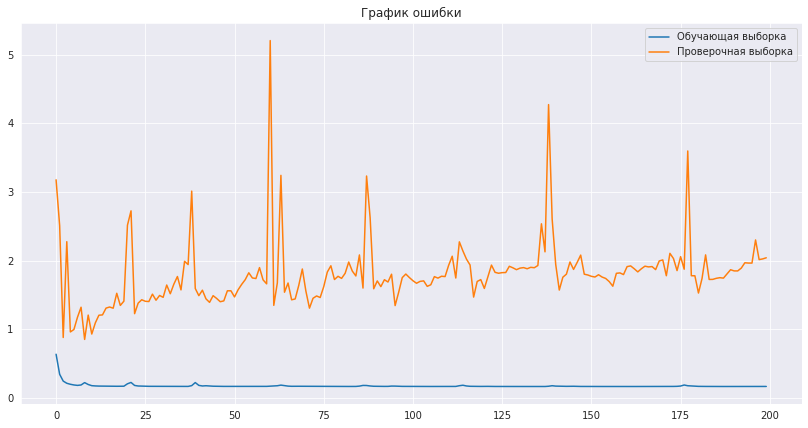

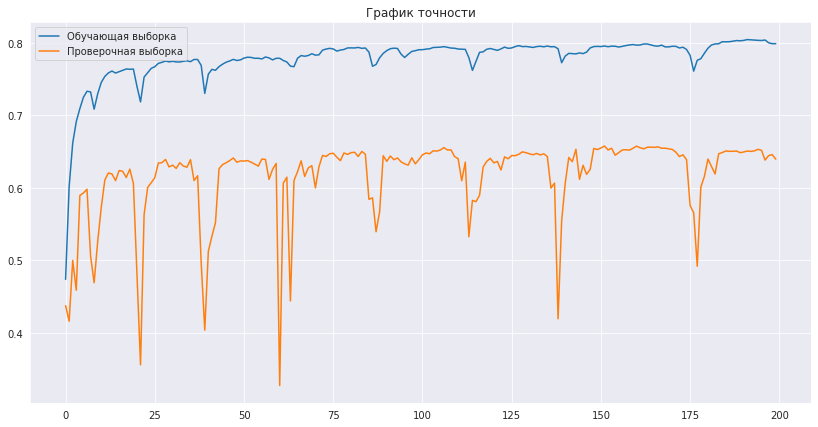

Epoch 1/200
35/35 [==============================] - 38s 1s/step - loss: 0.6168 - dice_coef: 0.4818 - val_loss: 8.0800 - val_dice_coef: 0.2427
Epoch 2/200
35/35 [==============================] - 35s 996ms/step - loss: 0.3406 - dice_coef: 0.6155 - val_loss: 6.3559 - val_dice_coef: 0.2881
Epoch 3/200
35/35 [==============================] - 35s 989ms/step - loss: 0.2562 - dice_coef: 0.6688 - val_loss: 6.0283 - val_dice_coef: 0.2872
Epoch 4/200
35/35 [==============================] - 34s 975ms/step - loss: 0.2092 - dice_coef: 0.7079 - val_loss: 1.6230 - val_dice_coef: 0.4673
Epoch 5/200
35/35 [==============================] - 34s 975ms/step - loss: 0.1947 - dice_coef: 0.7287 - val_loss: 1.1503 - val_dice_coef: 0.5650
Epoch 6/200
35/35 [==============================] - 34s 973ms/step - loss: 0.1903 - dice_coef: 0.7391 - val_loss: 1.2078 - val_dice_coef: 0.4891
Epoch 7/200
35/35 [==============================] - 35s 989ms/step - loss: 0.1895 - dice_coef: 0.7435 - val_loss: 1.7002 - val

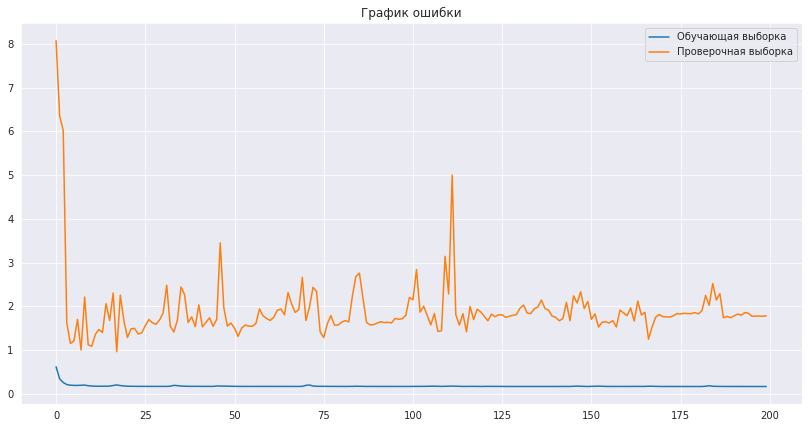

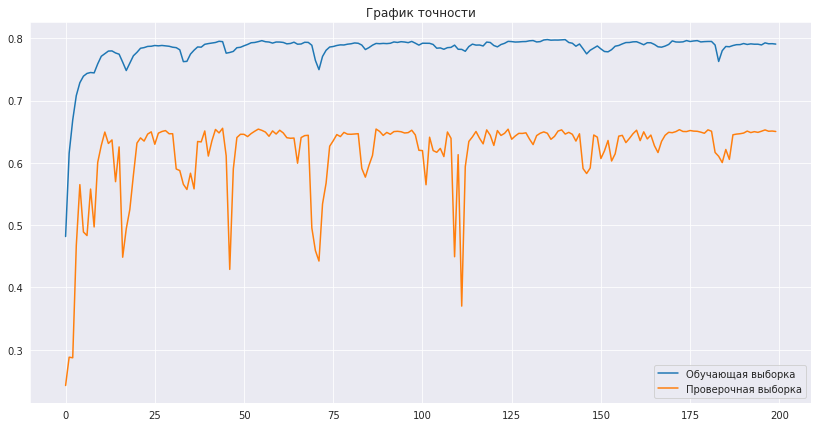

In [ ]:
for k in [2,3,4]:
  k_model = create_unet(k=k, num_classes=6, input_shape=(xLen, embeddingSize))
  k_history = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                          batch_size=320, epochs=200, verbose=1, validation_split=0.2)
  save_hist(k_history, f'/content/drive/MyDrive/Домашнее задание №27/hist_k_{k}.xlsx')

  plt.figure(figsize=(14,7))
  plt.plot(k_history.history['loss'], label='Обучающая выборка')
  plt.plot(k_history.history['val_loss'], label='Проверочная выборка')
  plt.legend()
  plt.title('График ошибки')
  plt.show()

  plt.figure(figsize=(14,7))
  plt.plot(k_history.history['dice_coef'], label='Обучающая выборка')
  plt.plot(k_history.history['val_dice_coef'], label='Проверочная выборка')
  plt.legend()
  plt.title('График точности')
  plt.show()

видим, что параметр к=4 дал лучший результат, попробуем обучить на большем количестве эпох, заодно поменяв learning_rate и попробуем разные оптимизаторы

Epoch 1/50
35/35 [==============================] - 124s 4s/step - loss: 0.5848 - dice_coef: 0.4907 - val_loss: 11.6039 - val_dice_coef: 0.0720
Epoch 2/50
35/35 [==============================] - 124s 4s/step - loss: 0.3074 - dice_coef: 0.6286 - val_loss: 5.5903 - val_dice_coef: 0.2477
Epoch 3/50
35/35 [==============================] - 124s 4s/step - loss: 0.2285 - dice_coef: 0.6856 - val_loss: 1.4488 - val_dice_coef: 0.4575
Epoch 4/50
35/35 [==============================] - 123s 4s/step - loss: 0.2046 - dice_coef: 0.7092 - val_loss: 0.9576 - val_dice_coef: 0.5840
Epoch 5/50
35/35 [==============================] - 124s 4s/step - loss: 0.1931 - dice_coef: 0.7276 - val_loss: 1.2386 - val_dice_coef: 0.5141
Epoch 6/50
35/35 [==============================] - 124s 4s/step - loss: 0.1894 - dice_coef: 0.7324 - val_loss: 1.0906 - val_dice_coef: 0.4990
Epoch 7/50
35/35 [==============================] - 124s 4s/step - loss: 0.1951 - dice_coef: 0.7347 - val_loss: 1.2356 - val_dice_coef: 0.587

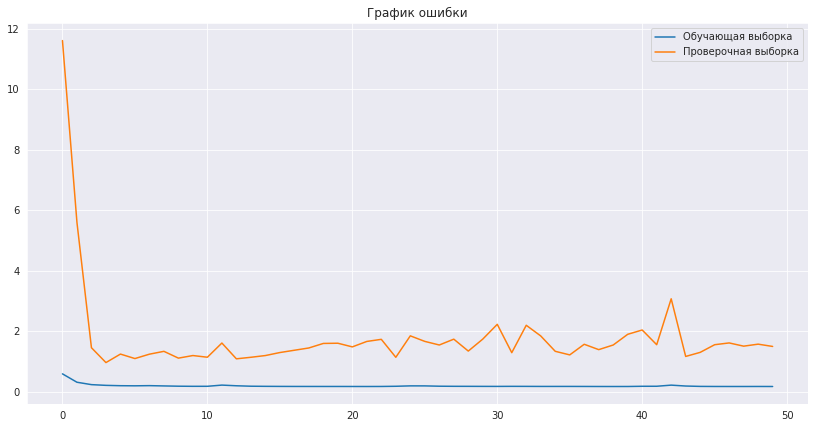

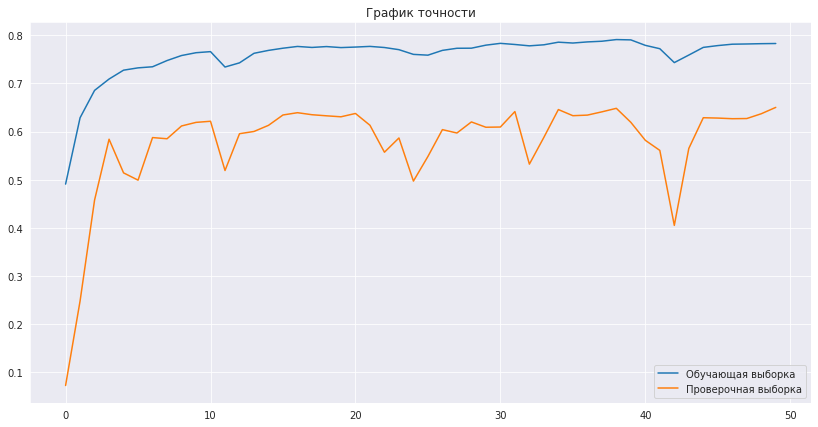

Epoch 1/50
35/35 [==============================] - 124s 4s/step - loss: 1.3715 - dice_coef: 0.1838 - val_loss: 1.4332 - val_dice_coef: 0.2022
Epoch 2/50
35/35 [==============================] - 124s 4s/step - loss: 1.3564 - dice_coef: 0.1869 - val_loss: 1.4300 - val_dice_coef: 0.2042
Epoch 3/50
35/35 [==============================] - 124s 4s/step - loss: 1.3414 - dice_coef: 0.1896 - val_loss: 1.4288 - val_dice_coef: 0.2058
Epoch 4/50
35/35 [==============================] - 124s 4s/step - loss: 1.3265 - dice_coef: 0.1925 - val_loss: 1.4252 - val_dice_coef: 0.2081
Epoch 5/50
35/35 [==============================] - 124s 4s/step - loss: 1.3118 - dice_coef: 0.1953 - val_loss: 1.4190 - val_dice_coef: 0.2109
Epoch 6/50
35/35 [==============================] - 124s 4s/step - loss: 1.2972 - dice_coef: 0.1983 - val_loss: 1.4104 - val_dice_coef: 0.2142
Epoch 7/50
35/35 [==============================] - 124s 4s/step - loss: 1.2829 - dice_coef: 0.2012 - val_loss: 1.4001 - val_dice_coef: 0.2177

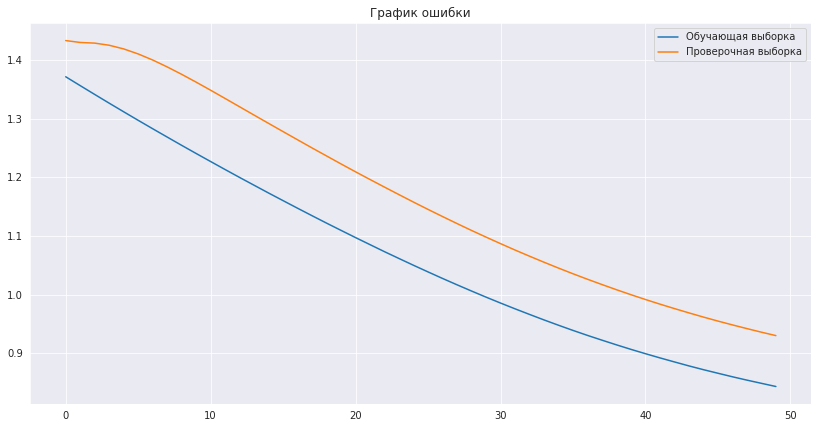

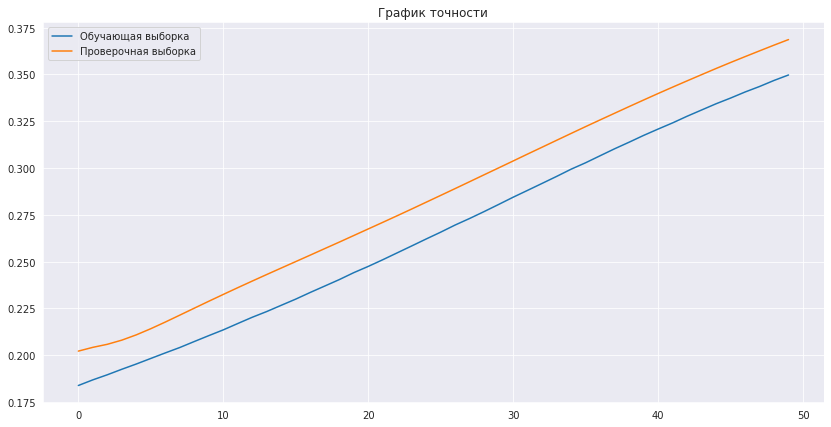

Epoch 1/50
35/35 [==============================] - 123s 4s/step - loss: 0.7462 - dice_coef: 0.4169 - val_loss: 3.3993 - val_dice_coef: 0.2177
Epoch 2/50
35/35 [==============================] - 123s 4s/step - loss: 0.5555 - dice_coef: 0.5102 - val_loss: 6.3481 - val_dice_coef: 0.2858
Epoch 3/50
35/35 [==============================] - 123s 4s/step - loss: 0.4446 - dice_coef: 0.5676 - val_loss: 9.5752 - val_dice_coef: 0.1057
Epoch 4/50
35/35 [==============================] - 123s 4s/step - loss: 0.3583 - dice_coef: 0.6200 - val_loss: 6.6363 - val_dice_coef: 0.1765
Epoch 5/50
35/35 [==============================] - 123s 4s/step - loss: 0.3076 - dice_coef: 0.6532 - val_loss: 2.9744 - val_dice_coef: 0.3133
Epoch 6/50
35/35 [==============================] - 123s 4s/step - loss: 0.2673 - dice_coef: 0.6843 - val_loss: 1.2448 - val_dice_coef: 0.4698
Epoch 7/50
35/35 [==============================] - 123s 4s/step - loss: 0.2392 - dice_coef: 0.7102 - val_loss: 1.3191 - val_dice_coef: 0.5149

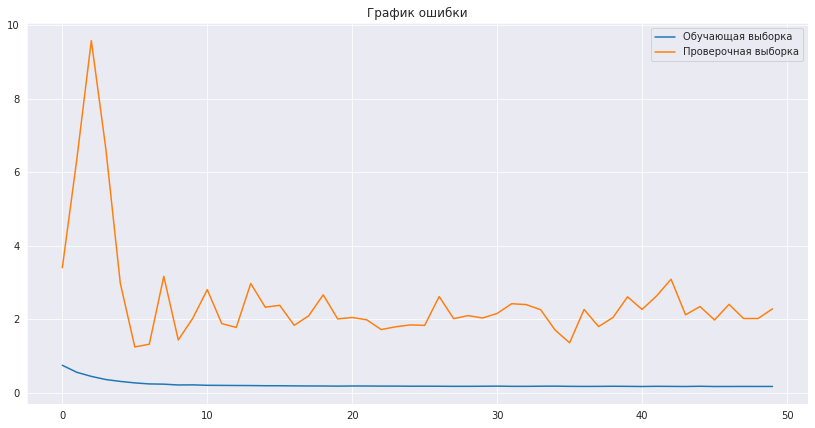

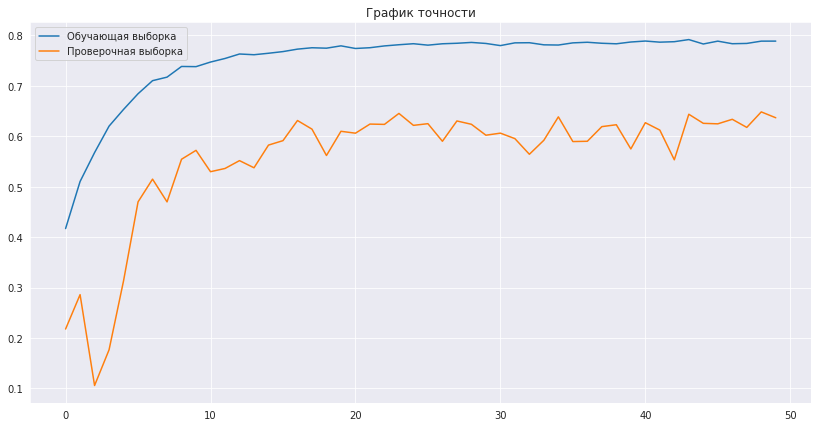

In [ ]:
for opt in enumerate([Adam(0.002), Adadelta(0.002), RMSprop(0.002)]):
  k_model = create_unet(k=4, num_classes=6, input_shape=(xLen, embeddingSize))

  k_model.compile(optimizer=opt[1], loss='categorical_crossentropy', metrics=[dice_coef])

  k_history = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                          batch_size=320, epochs=50, verbose=1, validation_split=0.2)
  save_hist(k_history, f'/content/drive/MyDrive/Домашнее задание №27/hist_k_4_{opt[0]}.xlsx')

  plt.figure(figsize=(14,7))
  plt.plot(k_history.history['loss'], label='Обучающая выборка')
  plt.plot(k_history.history['val_loss'], label='Проверочная выборка')
  plt.legend()
  plt.title('График ошибки')
  plt.show()

  plt.figure(figsize=(14,7))
  plt.plot(k_history.history['dice_coef'], label='Обучающая выборка')
  plt.plot(k_history.history['val_dice_coef'], label='Проверочная выборка')
  plt.legend()
  plt.title('График точности')
  plt.show()

предварительно видно, что оптимизатор ADAM(0.002) дал неплохой результат (0.65 по Val_dice_coef) 

**Максимальная точность 0.65 (по val_dice_coef)**

Но!
Ради интереса продолжим экспериментировать. 
Например, можно попробовать обучить сеть с ним на бОльшем числе эпох

оптимизатор Adadelta(0.002) увеличивает точность медленнее, но зато плавней и стабильно растет, также можно попробовать поставить на бОльшее число эпох



In [ ]:
k_model = create_unet(k=4, num_classes=6, input_shape=(xLen, embeddingSize))

k_model.compile(optimizer=Adam(0.002), loss='categorical_crossentropy', metrics=[dice_coef])

k_history_1 = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                        batch_size=320, epochs=150, verbose=1, validation_split=0.2)
save_hist(k_history_1, '/content/drive/MyDrive/Домашнее задание №27/hist_k_4_Adam_0.002.xlsx')

plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['loss'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['dice_coef'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

k_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=[dice_coef])

k_history_2 = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                        batch_size=320, epochs=100, verbose=1, validation_split=0.2)
save_hist(k_history_2, '/content/drive/MyDrive/Домашнее задание №27/hist_k_4_Adam_0_001.xlsx')
k_model.save( '/content/drive/My Drive/Домашнее задание №27/model_k_4_k_4_Adam_0_001.h5')
plt.figure(figsize=(14,7))
plt.plot(k_history_2.history['loss'], label='Обучающая выборка')
plt.plot(k_history_2.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(k_history_2.history['dice_coef'], label='Обучающая выборка')
plt.plot(k_history_2.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

Epoch 1/150
35/35 [==============================] - 66s 2s/step - loss: 0.5851 - dice_coef: 0.4960 - val_loss: 11.6037 - val_dice_coef: 0.0721
Epoch 2/150
35/35 [==============================] - 65s 2s/step - loss: 0.3068 - dice_coef: 0.6302 - val_loss: 2.1606 - val_dice_coef: 0.4289
Epoch 3/150
35/35 [==============================] - 65s 2s/step - loss: 0.2300 - dice_coef: 0.6863 - val_loss: 1.4026 - val_dice_coef: 0.5130
Epoch 4/150
35/35 [==============================] - 64s 2s/step - loss: 0.2000 - dice_coef: 0.7207 - val_loss: 1.1076 - val_dice_coef: 0.5516
Epoch 5/150
35/35 [==============================] - 65s 2s/step - loss: 0.1901 - dice_coef: 0.7365 - val_loss: 1.0915 - val_dice_coef: 0.5667
Epoch 6/150
35/35 [==============================] - 65s 2s/step - loss: 0.1866 - dice_coef: 0.7442 - val_loss: 0.8855 - val_dice_coef: 0.5816
Epoch 7/150
35/35 [==============================] - 65s 2s/step - loss: 0.1844 - dice_coef: 0.7491 - val_loss: 1.2854 - val_dice_coef: 0.571

исполнение ячейки вылетело с неизвестной ошибкой, но уже видно, что точность больше 0.64, можно не перезапускать этот вариант 

Epoch 1/150
35/35 [==============================] - 62s 2s/step - loss: 1.2493 - dice_coef: 0.2099 - val_loss: 1.3302 - val_dice_coef: 0.2328
Epoch 2/150
35/35 [==============================] - 63s 2s/step - loss: 1.2377 - dice_coef: 0.2130 - val_loss: 1.3390 - val_dice_coef: 0.2303
Epoch 3/150
35/35 [==============================] - 63s 2s/step - loss: 1.2264 - dice_coef: 0.2159 - val_loss: 1.3389 - val_dice_coef: 0.2309
Epoch 4/150
35/35 [==============================] - 63s 2s/step - loss: 1.2154 - dice_coef: 0.2190 - val_loss: 1.3339 - val_dice_coef: 0.2332
Epoch 5/150
35/35 [==============================] - 63s 2s/step - loss: 1.2046 - dice_coef: 0.2217 - val_loss: 1.3262 - val_dice_coef: 0.2364
Epoch 6/150
35/35 [==============================] - 63s 2s/step - loss: 1.1941 - dice_coef: 0.2247 - val_loss: 1.3170 - val_dice_coef: 0.2400
Epoch 7/150
35/35 [==============================] - 63s 2s/step - loss: 1.1837 - dice_coef: 0.2276 - val_loss: 1.3069 - val_dice_coef: 0.2438

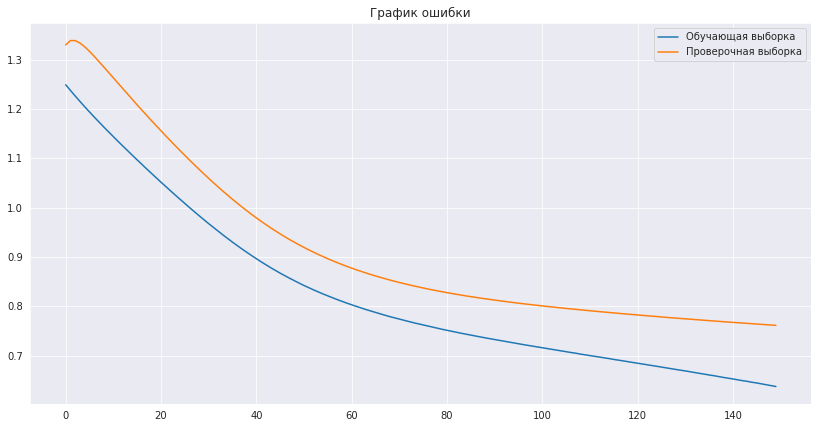

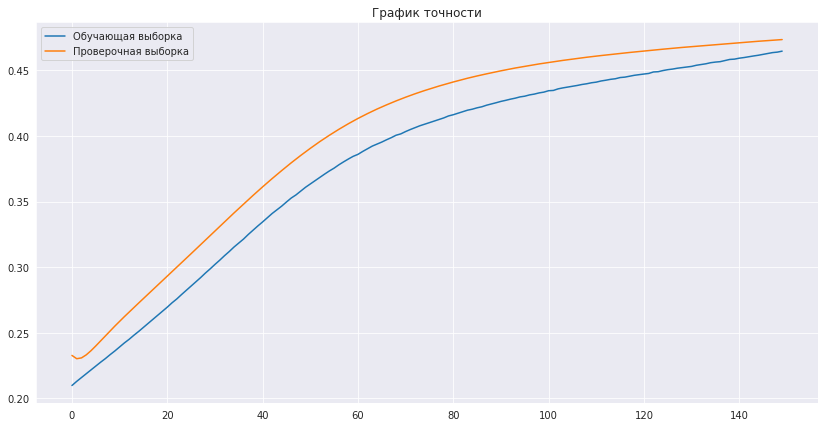

In [ ]:
k_model = create_unet(k=4, num_classes=6, input_shape=(xLen, embeddingSize))
k_model.compile(optimizer=Adadelta(0.002), loss='categorical_crossentropy', metrics=[dice_coef])

k_history_1 = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                        batch_size=320, epochs=150, verbose=1, validation_split=0.2)
save_hist(k_history_1, '/content/drive/MyDrive/Домашнее задание №27/hist_k_4_Adadelta_0_002.xlsx')
k_model.save( '/content/drive/My Drive/Домашнее задание №27/model_k_4_Adadelta_0_002.h5' )
plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['loss'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['dice_coef'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

In [ ]:
k_model = create_unet(k=4, num_classes=6, input_shape=(xLen, embeddingSize))
k_model.compile(optimizer=Adadelta(0.002), loss='categorical_crossentropy', metrics=[dice_coef])

k_history_1 = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                        batch_size=320, epochs=500, verbose=1, validation_split=0.2)
save_hist(k_history_1, '/content/drive/MyDrive/Домашнее задание №27/hist_k_4_Adadelta_0_002.xlsx')
k_model.save( '/content/drive/My Drive/Домашнее задание №27/model_k_4_Adadelta_0_002.h5' )
plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['loss'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(k_history_1.history['dice_coef'], label='Обучающая выборка')
plt.plot(k_history_1.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

Epoch 1/500
35/35 [==============================] - 61s 2s/step - loss: 1.5525 - dice_coef: 0.1484 - val_loss: 1.6478 - val_dice_coef: 0.1609
Epoch 2/500
35/35 [==============================] - 62s 2s/step - loss: 1.5325 - dice_coef: 0.1515 - val_loss: 1.5992 - val_dice_coef: 0.1689
Epoch 3/500
35/35 [==============================] - 61s 2s/step - loss: 1.5125 - dice_coef: 0.1546 - val_loss: 1.5836 - val_dice_coef: 0.1726
Epoch 4/500
35/35 [==============================] - 62s 2s/step - loss: 1.4930 - dice_coef: 0.1578 - val_loss: 1.5794 - val_dice_coef: 0.1747
Epoch 5/500
35/35 [==============================] - 62s 2s/step - loss: 1.4737 - dice_coef: 0.1610 - val_loss: 1.5765 - val_dice_coef: 0.1768
Epoch 6/500
35/35 [==============================] - 62s 2s/step - loss: 1.4548 - dice_coef: 0.1645 - val_loss: 1.5712 - val_dice_coef: 0.1793
Epoch 7/500
35/35 [==============================] - 62s 2s/step - loss: 1.4360 - dice_coef: 0.1677 - val_loss: 1.5628 - val_dice_coef: 0.1823

In [ ]:
k_model = create_unet(k=4, num_classes=6, input_shape=(xLen, embeddingSize))

k_model.compile(optimizer=RMSprop(0.002), loss='categorical_crossentropy', metrics=[dice_coef])

k_history = k_model.fit(new_xTrainGENSIM, new_yTrainGENSIM,
                        batch_size=320, epochs=200, verbose=1, validation_split=0.2)
save_hist(k_history_1, '/content/drive/MyDrive/Домашнее задание №27/hist_k_4_RMSprop_0.002.xlsx')
k_model.save( '/content/drive/My Drive/Домашнее задание №27/model_k_4_RMSprop_0_002.h5' )
plt.figure(figsize=(14,7))
plt.plot(k_history.history['loss'], label='Обучающая выборка')
plt.plot(k_history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(k_history.history['dice_coef'], label='Обучающая выборка')
plt.plot(k_history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()


Epoch 1/200


KeyboardInterrupt: ignored